# CIS 5450 Final Project: The Effect of COVID-19 on Stock Prices
Presented by Kristine Yip, Tin Do, Ben Chan

## Background and Motivation
In this project, we will explore the effects of the COVID-19 pandemic on stock prices. More specifically, we seek to determine how COVID-19 affected the stock market. We plan to analyse this broad research question from several perspectives:
1. How do COVID-19 cases, deaths, and vaccinations correlate with stock percentage changes?
2. Using rigorous statistical testing, where exactly did the stock prices indicate the start of the COVID-19 pandemic?
3. Were some industries more heavily affected than others?

Our hypotheses for these two questions were:

1. We predict that there will be a strong positive correlation between vaccinations and stock price percentage changes, and a strong negative correlation between deaths/cases and stock price percentage changes.
2. We anticipate that we will detect an "anomaly" right at the spike of the COVID-19 data. 
3. We anticipate that all sectors will be affected by the COVID-19 pandemic, but in varying ways and to varying degrees. For example, companies like Zoom (and other tech companies) may have been positively impacted by the pandemic, while companies within the hospitality and travel industry may have been negatively impacted. 

# Section 0: Imports and Setup

In [ ]:
%%capture
!pip install yfinance

In [ ]:
%%capture
!pip install py_stringsimjoin
!pip install py-stringmatching
!pip install wikipedia

In [ ]:
import py_stringsimjoin as ssj
import py_stringmatching as sm

In [ ]:
import urllib.request
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
import math
import json
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Section 1: Loading Datasets

In this section, we will take the following steps: \
1. Load our datasets into pandas dataframes
2. Perform basic preprocessing, such as removing null values
3. Compute summary statistics 
4. Prepare our data for analysis by creating new columns as necessary

## Import A: Fortune 1000 from 2015-2022 Data

Here we import, inspect, and preprocess data for the Fortune 1000 companies between the years of 2015 and 2022 (inclusive). We chose to load data starting from 2015 because this provides a good amount of baseline pre-covid data for us to compare with our covid-era (2020-2021) and post-covid (2022) data.

### Import Fortune 1000 Companies Data

The Fortune 1000 data we will use comes from a set of 8 separate datasets found online [here](https://www.someka.net/products/fortune-1000-list-excel-template/). Each dataset contains the names, ranks, revenues, and profits of companies within the Fortune 1000 for one year.

In [ ]:
years=list(range(2015, 2023))
dfs=[]

for year in years:
  file_path=f"/content/drive/My Drive/CIS 545 Final Project Files/Fortune-1000-{year}.csv"
  df=pd.read_csv(file_path)
  df['year']=year

  # remove newline characters and dates from column names
  pattern = re.compile(r'[\n$]')
  new_columns = [re.sub(pattern, '', col) for col in df.columns]
  pattern = re.compile(r'Market Value As of \d{1,2}/\d{1,2}/\d{2}')
  
  new_columns = [re.sub(pattern, 'Market Value As of March', col) for col in new_columns]
  df.columns = new_columns
  dfs.append(df)

fortune_df=pd.concat(dfs, ignore_index=True)

# check to see if data looks correct
fortune_df.head()

,Rank,Company Name,Number of Employees,Change in Rank,Revenues(millions),Revenue Change,Profits(millions),Profit Change,Assets(millions),Market Value As of March (m),year,Previous Rank
0,1,Walmart,"2,200,000",-,"$485,820",2.00%,"$16,363.00",2.10%,"$203,706","$265,344",2015,NaN
1,2,Exxon Mobil,"83,700",-,"$382,798",-6.10%,"$32,520.00",-0.20%,"$349,493","$356,549",2015,NaN
2,3,Chevron,"64,700",-,"$203,829",-7.50%,"$19,241.00",-10.20%,"$266,026","$197,381",2015,NaN
3,4,Berkshire Hathaway,"316,000",-,"$194,718",6.90%,"$19,872.00",2.00%,"$526,186","$357,344",2015,NaN
4,5,Apple,"97,200",-,"$182,874",7.00%,"$39,510.00",6.70%,"$231,839","$724,773",2015,NaN


### Preprocessing Fortune 1000

### Preprocessing Fortune 1000

From the below two cells, we see that most of the columns of our imported datatype have a type of `object`. We need to change the datatypes of our numerical columns to `int64` or `float`. Additionally, we need to handle the nulls within the `Change in Rank`, `Market Value As of March (m)`, and `Previous Rank` columns.

In [ ]:
# from here, we see that we need to change the dtypes of the numerical columns to int/float
fortune_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Rank                          8000 non-null   int64 
 1   Company Name                  8000 non-null   object
 2   Number of Employees           8000 non-null   object
 3   Change in Rank                6000 non-null   object
 4   Revenues(millions)            8000 non-null   object
 5   Revenue Change                8000 non-null   object
 6   Profits(millions)             8000 non-null   object
 7   Profit Change                 8000 non-null   object
 8   Assets(millions)              8000 non-null   object
 9   Market Value As of March (m)  7970 non-null   object
 10  year                          8000 non-null   int64 
 11  Previous Rank                 1929 non-null   object
dtypes: int64(2), object(10)
memory usage: 750.1+ KB


In [ ]:
# we have null values in the Previous Rank, Change in Rank, and Market Value columns
fortune_df.isna().sum()

Rank                               0
Company Name                       0
Number of Employees                0
Change in Rank                  2000
Revenues(millions)                 0
Revenue Change                     0
Profits(millions)                  0
Profit Change                      0
Assets(millions)                   0
Market Value As of March (m)      30
year                               0
Previous Rank                   6071
dtype: int64

Since the data sources for each year of Fortune 1000 data each contain different formatting, some datasets used `-` in to represent the concept of 'no change' while otheres used `NaN`.

We will also re-make the `Previous Rank` column. Although our dataframe `fortune_df` currently has this column, a lot of the values in this column are null. This is because some of the Fortune 1000 data sources included this column, while others did not. Additionally, if a company joined the fortune 1000 recently and has no rank for the previous year, or if we do not have data for the previous year (i.e. for the first year 2015), we will impute `-1` to represent this.

We also won't be needing the `Market Value As of March (m)` column in our later analysis, so we will drop it here!

In [ ]:
# replace `-` and `NAN`s in Change in Rank column to 0
fortune_df = fortune_df.replace('-', 0)
fortune_df['Change in Rank'] = fortune_df['Change in Rank'].fillna(0)

# Make the previous rank column.
fortune_df['Previous Rank'] = fortune_df.sort_values(by=['Company Name', 'year'], ascending=[True, True]).groupby(['Company Name'])['Rank'].shift()
fortune_df['Previous Rank'] = fortune_df['Previous Rank'].fillna(-1)

In [ ]:
# drop the unnecessary column from fortune_df
fortune_df = fortune_df.drop(['Market Value As of March (m)'], axis=1)

Now we will make sure the column types are as follows:
- String: `Company Name`
- int64: `Rank`, `Number of Employees`, `Change in Rank`, `Revenues(millions)`, `Assets(millions)`, `year`, `Previous Rank`
- float: `Profit Change`, `Revenue Change`, `Profits(millions)`

In [ ]:
fortune_df[fortune_df['Profit Change']=="NAN%"]

,Rank,Company Name,Number of Employees,Change in Rank,Revenues(millions),Revenue Change,Profits(millions),Profit Change,Assets(millions),year,Previous Rank
2560,561,Dynegy,"2,457",0,"$4,318",11.60%,"-$1,240.00",NAN%,"$13,053",2017,606.0
2865,866,Party City Holdco,"14,000",0,"$2,283",-0.50%,$117.50,NAN%,"$3,394",2017,894.0
2925,926,Ferrellgas Partners,"3,908",0,"$2,039",0.70%,-$665.40,NAN%,"$1,683",2017,962.0


In [ ]:
fortune_df = fortune_df.drop(index=fortune_df[fortune_df['Profit Change']=="NAN%"].index)
fortune_df[fortune_df['Profit Change']=="NAN%"]

,Rank,Company Name,Number of Employees,Change in Rank,Revenues(millions),Revenue Change,Profits(millions),Profit Change,Assets(millions),year,Previous Rank


Now we will make sure the column types are as follows:
- String: `Company Name`
- int64: `Rank`, `Number of Employees`, `Change in Rank`, `Revenues(millions)`, `Assets(millions)`, `year`, `Previous Rank`
- float: `Profit Change`, `Revenue Change`, `Profits(millions)`

In [ ]:
num_columns = list(fortune_df.columns)
num_columns.remove('Company Name')
float_columns = ['Profit Change', 'Revenue Change', 'Profits(millions)']
int_columns = [c for c in list(num_columns) if c not in float_columns]

print(f"Numerical columns: {num_columns}")
print(f"Float columns: {float_columns}")
print(f"Int64 columns: {int_columns}")

Numerical columns: ['Rank', 'Number of Employees', 'Change in Rank', 'Revenues(millions)', 'Revenue Change', 'Profits(millions)', 'Profit Change', 'Assets(millions)', 'year', 'Previous Rank']
Float columns: ['Profit Change', 'Revenue Change', 'Profits(millions)']
Int64 columns: ['Rank', 'Number of Employees', 'Change in Rank', 'Revenues(millions)', 'Assets(millions)', 'year', 'Previous Rank']


In [ ]:
# remove commas, $, and % from numerical cols
for col in num_columns:
  fortune_df[col] = fortune_df[col].apply(lambda x : str(x).replace(',', '').replace('$', '').replace('%', ''))

# change column types
for col in float_columns:
  fortune_df[col] = fortune_df[col].astype(float)

# remove decimal points from integer columns and convert
for col in int_columns:
  fortune_df[col] = fortune_df[col].apply( lambda x : int(x.split('.')[0]))
  fortune_df[col] = fortune_df[col].astype('int64')

Now the column types match what we need, and we have no null values!

In [ ]:
fortune_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7997 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rank                 7997 non-null   int64  
 1   Company Name         7997 non-null   object 
 2   Number of Employees  7997 non-null   int64  
 3   Change in Rank       7997 non-null   int64  
 4   Revenues(millions)   7997 non-null   int64  
 5   Revenue Change       7997 non-null   float64
 6   Profits(millions)    7997 non-null   float64
 7   Profit Change        7997 non-null   float64
 8   Assets(millions)     7997 non-null   int64  
 9   year                 7997 non-null   int64  
 10  Previous Rank        7997 non-null   int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 749.7+ KB


In [ ]:
fortune_df.head()

,Rank,Company Name,Number of Employees,Change in Rank,Revenues(millions),Revenue Change,Profits(millions),Profit Change,Assets(millions),year,Previous Rank
0,1,Walmart,2200000,0,485820,2.0,16363.0,2.1,203706,2015,-1
1,2,Exxon Mobil,83700,0,382798,-6.1,32520.0,-0.2,349493,2015,-1
2,3,Chevron,64700,0,203829,-7.5,19241.0,-10.2,266026,2015,-1
3,4,Berkshire Hathaway,316000,0,194718,6.9,19872.0,2.0,526186,2015,-1
4,5,Apple,97200,0,182874,7.0,39510.0,6.7,231839,2015,-1


## Import B: Stock Data

In this section we will obtain, inspect, and preprocess data for the stock prices between the years of 2000 and 2022 (inclusive) of companies within the Fortune 1000 companies. We decided to start loading the stock data from the year 2000 in order to provide enough the LSTM model that we will be training later.

### Import Stock Ticker Data

For those who don't know, a stock tickers are codes that represent publicly traded companies in the stock market. We need to obtain the stock ticker code of a company in order to get the historical stock data of the company.

#### Web Scraping Wikipedia
We couldn't find a satisfactory dataset online for the stock ticker data, so we decided to web scrape Wikipedia for these values. We used the Wikipedia and BeautifulSoup python packages and were able to get the stock tickers for most of the companies within `fortune_df`.

In [ ]:
# Imports for web scraping (SHOULD THIS BE MOVED TO SECTION 0?)
import requests
from bs4 import BeautifulSoup
import wikipedia as wp
import string

In [ ]:
# sparse the Wikipedia page and find the ticker on the it
def extract_ticker(page):
  wanted_li = ""
  try: 
    print("looking for " + page.title.text)
    rows = page.select('table[class="infobox vcard"] > tbody > tr:has(> th > div > a[title="Ticker symbol"])')
    for row in rows:
      wanted_li = row.select_one("td a:nth-of-type(2)")
      print("Found " + wanted_li.text)
      wanted_li = wanted_li.text
  except Exception as e:
    print(f"An error occurred: {e}")
  finally:
    return wanted_li

In [ ]:
result = []
fortune_df = pd.read_csv('/content/drive/MyDrive/CIS 545 Final Project Files/fortune_df.csv')

unique_company_names= fortune_df.drop_duplicates(subset=['company_name'])
for company_name in unique_company_names['company_name'].tolist():
  company_name = company_name
  query = f"{company_name} Company"

  # get a list of possible urls for cases where company names are hard to find.
  # for example Apple Inc. is named Apple in our data 
  urls = ["https://en.wikipedia.org/wiki/" + page for page in wp.search(query, results=5)]

  did = False
  for page_url in urls:
    try:
      res = requests.get(page_url)

      # Raise an exception if the response status code is not 200 OK
      res.raise_for_status()
      #Save page and url for later use.
      soup = BeautifulSoup(res.content, 'html.parser')
      wanted_ticker = extract_ticker(soup)
      # break out of the for loop after we collected the desired ticker
      # otherwise, continue searching
      if wanted_ticker != "" and wanted_ticker != None:
        result.append(wanted_ticker)
        did = True
        break;
    except Exception as e:
      print(f"An error occurred: {e}")
      #result.append("")
  if not did:
    result.append("")

#### Entity Resolution with Jaccard Similarity
Join the master stock list with our list of remaining companies names using jaccard similarity. We will get tickers for companies which have names "close enough" to the names in the list (the threshold is 0.68 - explain why we chose this threshold)

For the few companies which we were not able to scrape stock tickers for, we used a master list of stock ticker data from [here](https://stockanalysis.com/stocks/). We weren't able to use solely this master list because this list had very large differences with `fortune_df` in company names which couldn't overall be resolved using string similarity methods.

We create the `company_left` dataframe, which contains the names of all the companies which we do not have stock tickers for.

In [ ]:
unique_company_names['ticker'] = result
company_tickers = unique_company_names[['company_name']]
company_tickers['ticker'] = result
company_tickers.head()

In the below cell we preprocess `stock_master_list_df` in preparation for entity resolution and joining with.

In [ ]:
company_left = company_tickers[company_tickers['ticker'] == ''][['company_name']]
company_left = company_left.reset_index()
company_left.head()

,index,company_name
0,61,Ingram Micro
1,72,Delta Air Lines
2,76,Tesoro
3,77,Liberty Mutual Insurance Group
4,83,Safeway


We will now use Jaccard Similarity from the Magellan Python package with a threshold of 0.35 to join `company_left` with the master ticker list `stock_master_list_df`.

In [ ]:
# use a master list 
stock_master_list_df = pd.read_csv('/content/drive/My Drive/CIS 545 Final Project Files/stocks-list.csv')
# allows the dataframe a unique index to link with the other dataframe
stock_master_list_df = stock_master_list_df.reset_index()
stock_master_list_df.head()

,index,Symbol,Company Name,Industry,Market Cap
0,0,A,"Agilent Technologies, Inc.",Diagnostics & Research,4.051709e+10
1,1,AA,Alcoa Corporation,Aluminum,6.742711e+09
2,2,AAC,Ares Acquisition Corporation,Shell Companies,7.473299e+08
3,3,AACG,ATA Creativity Global,Education & Training Services,5.969735e+07
4,4,AACI,Armada Acquisition Corp. I,Shell Companies,2.101041e+08


In [ ]:

# rename the column name from Company Name to company_name
stock_master_list_df = stock_master_list_df.rename(columns={'Company Name': 'company'})
# match any string that ends with either "Corporation" or "Inc." to assist with record linking later
p = re.compile(r"(.*)(Corporation|, Inc.| Inc| Company| Limited)")
stock_master_list_df['company'] = stock_master_list_df.apply(lambda row: p.sub(r"\1 ", row['company']).strip(), axis=1)
# remove punctuation because it seems to mess with the record linking too
stock_master_list_df['company'] = stock_master_list_df.apply(lambda row: row['company'].replace(",", "").replace(".", ""), axis=1)


In [ ]:
# compare with a master list to get all the possible stock tickers that was not found during the web scraping process
# referenced Slide 4
tok = sm.QgramTokenizer(qval=2,return_set=True)
output_pairs = ssj.jaccard_join(company_left, stock_master_list_df, l_key_attr='index', r_key_attr='index', \
                                l_join_attr = 'company_name', r_join_attr='company', \
                                l_out_attrs = ['company_name'], r_out_attrs=['company', 'Symbol'], \
                                tokenizer=tok, threshold=0.35, )

# only get the one with high similarity score
temp = output_pairs[output_pairs['_sim_score'] > 0.68]
temp.head()

In [ ]:
temp = temp[['l_company_name', 'r_Symbol']]
# rename the column
temp1 = temp.rename(columns={'l_company_name': 'company_name', 'r_Symbol':'ticker'})
temp1.head()

,company_name,ticker
16,AGNC Investment,AGNC
41,AMN Healthcare Services,AMN
53,APi Group,APG
65,Archrock,AROC
148,Builders FirstSource,BLDR


Finally, we keep all of the companies that we have found a valid ticker for in `final_companies_df`

In [ ]:
concatenated_df = pd.concat([company_tickers, temp1], axis=0)
# only take companies that has a ticker
final_companies_df = concatenated_df[concatenated_df['ticker'].str.len() > 0]
final_companies_df = final_companies_df.drop_duplicates(subset=['company_name'])
final_companies_df.head()

,company_name,ticker
0,Walmart,WMT
1,Exxon Mobil,XOM
2,Chevron,CVX
3,Berkshire Hathaway,BRK.A
4,Apple,AAPL


### Import Sector Data

We imported the sector data using the yahooo finance python package. This package allows us to obtain the sector information of a company by providing a company ticker.

In [ ]:
# convert ticker to the company sector
def get_sector(ticker):
  try:
    # error can be caused by weird ticker during the scraping process
    # for example: look at Sears Hometown & Outlet Stores ticker or 
    # Tower International ticker
    if ticker is not None and ticker.isalpha() and len(ticker) > 0:
        ticker = ticker.replace(".", "-")
        print(ticker)
        my_sector =  yf.Ticker(ticker).info['sector']
        return my_sector
  except Exception as e:
    print(f"An error occurred: {e}")

final_companies_df['sector'] = final_companies_df['ticker'].apply(get_sector)


In [ ]:
# save the final result to a csv file
final_companies_df

### Import Stock Price Data

Now, we can finally get the stock price data for each company using our dataframe `company_tickers`. We will once again use the Yahoo Finance python package, and save the stock price data into a pandas dataframe called ```stock_prices_df```.

In [ ]:
company_tickers = pd.read_csv('/content/drive/MyDrive/CIS 545 Final Project Files/company_tickers.csv')
company_tickers

,company_name,ticker,sector
0,Walmart,WMT,Consumer Defensive
1,Exxon Mobil,XOM,Energy
2,Chevron,CVX,Energy
3,Berkshire Hathaway,BRK.A,NaN
4,Apple,AAPL,Technology
...,...,...,...
1387,Universal,UVV,Consumer Defensive
1388,Encore Wire,WIRE,Industrials
1389,ContextLogic,WISH,Consumer Cyclical
1390,Yellow,YELL,Industrials


Here we load the stock information for our top companies from the indexes in ```stock_prices_df```.

In [ ]:
company_tickers['ticker'].dropna()

0         WMT
1         XOM
2         CVX
3       BRK.A
4        AAPL
        ...  
1387      UVV
1388     WIRE
1389     WISH
1390     YELL
1391        Z
Name: ticker, Length: 1392, dtype: object

In [ ]:
import yfinance as yf

stock_list = company_tickers['ticker'].dropna().tolist()
print('stock_list:', stock_list)

start_date = '2000-01-01'
end_date = '2023-04-15'

stock_prices_df = yf.download(stock_list, interval='1d', start=start_date, end=end_date, group_by='ticker')

stock_prices_df.head()

stock_list: ['WMT', 'XOM', 'CVX', 'BRK.A', 'AAPL', 'GM', 'PSX', 'GE', 'F', 'CVS', 'MCK', 'T', 'VLO', 'UNH', 'VZ', 'ABC', 'FNMA', 'COST', 'HPQ', 'KR', 'JPM', '002352', 'BAC', 'IBM', 'MPC', 'CAH', 'BA', 'C', 'AMZN', 'WFC', 'MSFT', 'PG', 'HD', 'ADM', 'WBA', 'TGT', 'JNJ', 'ELV', 'MET', 'GOOGL', 'MMC', 'FMCC', 'CMCSA', 'PEP', 'RTX', 'AIG', 'UPS', 'DOW', 'CVS', 'LOW', 'COP', 'INTC', 'ET', 'CAT', 'PRU', 'PFE', 'DIS', 'HUM', 'EPD', 'CSCO', 'SYY', 'KO', 'LMT', 'FDX', 'JCI', 'PAA', 'INT', 'CHSCP', 'AAL', 'MRK', 'BBY', 'HON', 'HCA', 'GS', 'UAL', 'MET', 'ORCL', 'MS', 'TSN', 'FGPR', 'DE', 'AXP', 'ALL', 'CI', 'MDLZ', 'SNEX', 'HAL', 'FOXA', 'MMM', 'TSX', 'GD', 'PM', 'TJX', 'M', 'NKE', '532755', 'AVT', 'MCD', 'EXC', 'TRV', 'QCOM', 'IP', 'OXY', 'DUK', 'RAD', 'GILD', 'BKR', 'EMR', 'DELL', 'UNP', 'NOC', 'AA', 'COF', 'NOV', 'USFD', 'RTX', 'ARW', 'AFL', 'ABT', 'CYH', 'FLR', 'FCX', 'USB', 'NUE', 'KMB', 'HES', 'CHK', 'XRX', 'MAN', 'AMGN', 'ABBV', 'DHR', 'WHR', 'PBF', 'DINO', 'LLY', 'DVN', 'PGR', 'CMI', 'IEP'

EA                                              \
                          Open       High        Low      Close  Adj Close   
Date                                                                         
2000-01-03 00:00:00  21.250000  28.765625  20.593750  25.265625  24.922916   
2000-01-04 00:00:00  23.750000  24.500000  22.312500  22.343750  22.040670   
2000-01-05 00:00:00  22.000000  24.375000  21.515625  22.328125  22.025255   
2000-01-06 00:00:00  22.062500  22.625000  19.843750  20.000000  19.728714   
2000-01-07 00:00:00  21.015625  21.656250  20.312500  20.593750  20.314411   

                                      JPM                                   \
                        Volume       Open       High        Low      Close   
Date                                                                         
2000-01-03 00:00:00  9040800.0  49.833332  50.250000  48.083332  48.583332   
2000-01-04 00:00:00  6331200.0  47.083332  47.458332  46.125000  47.250000   
2000-01-05 00:00:00  5072000.0  46.833332  48.375000  46.000000  46.958332   
2000-01-06 00:00:00  6408400.0  46.750000  48.625000  46.500000  47.625000   
2000-01-07 00:00:00  5456400.0  48.416668  49.000000  47.333332  48.500000   

                     ...   ACHC                                 WFC            \
                     ...    Low  Close Adj Close   Volume      Open      High   
Date                 ...                                                        
2000-01-03 00:00:00  ...  3.000  3.375     3.375    375.0  20.15625  20.18750   
2000-01-04 00:00:00  ...  3.375  3.375     3.375     25.0  18.62500  18.84375   
2000-01-05 00:00:00  ...  2.750  3.250     3.250  18275.0  18.50000  18.87500   
2000-01-06 00:00:00  ...  3.000  3.000     3.000    700.0  18.53125  19.50000   
2000-01-07 00:00:00  ...  2.875  2.875     2.875   7150.0  19.62500  19.84375   

                                                                
                          Low     Close  Adj Close      Volume  
Date                                                            
2000-01-03 00:00:00  19.00000  19.56250  10.369648   9037000.0  
2000-01-04 00:00:00  18.00000  18.59375   9.856133  15237200.0  
2000-01-05 00:00:00  18.03125  18.40625   9.756745   8228200.0  
2000-01-06 00:00:00  18.46875  19.21875  10.187434   8326800.0  
2000-01-07 00:00:00  19.28125  19.56250  10.369648   7711200.0  

[5 rows x 6480 columns]

In [ ]:
stock_prices_df.head()

EA                                              \
                          Open       High        Low      Close  Adj Close   
Date                                                                         
2000-01-03 00:00:00  21.250000  28.765625  20.593750  25.265625  24.922916   
2000-01-04 00:00:00  23.750000  24.500000  22.312500  22.343750  22.040670   
2000-01-05 00:00:00  22.000000  24.375000  21.515625  22.328125  22.025255   
2000-01-06 00:00:00  22.062500  22.625000  19.843750  20.000000  19.728714   
2000-01-07 00:00:00  21.015625  21.656250  20.312500  20.593750  20.314411   

                                      JPM                                   \
                        Volume       Open       High        Low      Close   
Date                                                                         
2000-01-03 00:00:00  9040800.0  49.833332  50.250000  48.083332  48.583332   
2000-01-04 00:00:00  6331200.0  47.083332  47.458332  46.125000  47.250000   
2000-01-05 00:00:00  5072000.0  46.833332  48.375000  46.000000  46.958332   
2000-01-06 00:00:00  6408400.0  46.750000  48.625000  46.500000  47.625000   
2000-01-07 00:00:00  5456400.0  48.416668  49.000000  47.333332  48.500000   

                     ...   ACHC                                 WFC            \
                     ...    Low  Close Adj Close   Volume      Open      High   
Date                 ...                                                        
2000-01-03 00:00:00  ...  3.000  3.375     3.375    375.0  20.15625  20.18750   
2000-01-04 00:00:00  ...  3.375  3.375     3.375     25.0  18.62500  18.84375   
2000-01-05 00:00:00  ...  2.750  3.250     3.250  18275.0  18.50000  18.87500   
2000-01-06 00:00:00  ...  3.000  3.000     3.000    700.0  18.53125  19.50000   
2000-01-07 00:00:00  ...  2.875  2.875     2.875   7150.0  19.62500  19.84375   

                                                                
                          Low     Close  Adj Close      Volume  
Date                                                            
2000-01-03 00:00:00  19.00000  19.56250  10.369648   9037000.0  
2000-01-04 00:00:00  18.00000  18.59375   9.856133  15237200.0  
2000-01-05 00:00:00  18.03125  18.40625   9.756745   8228200.0  
2000-01-06 00:00:00  18.46875  19.21875  10.187434   8326800.0  
2000-01-07 00:00:00  19.28125  19.56250  10.369648   7711200.0  

[5 rows x 6480 columns]

Here I take the stock prices df and do aggregation on it, which is specified by the user as an argument - flag. For example, if the flag is percentage change, then I take daily percentage change of each stock. I then filter out the company tickers that starts is not in the alphabets because they seem to be international companies, and thus have no obtained stock prices from Yahoo Finance. I group by sector to and then take the mean of each group. I also add a date column.

In [ ]:
'''
  argument:
    stock_prices_df: the dataframe you want to get the aggregation on
    flag: what aggreagation/stock value you want 
    start_date (optional): the start date of the stock data that you want (inclusive)
'''

def aggregate_sector_stock_prices(stock_prices_df, flag, start_date='1/1/2000'):
  if flag == 'pct':
    average_stock_prices_df = stock_prices_df.stack()
    average_stock_prices_df = average_stock_prices_df.loc[:, ['Open', 'Close'], :]
    # take percentage change between two continuous rows
    average_stock_prices_df = average_stock_prices_df.groupby('Date').pct_change()
    average_stock_prices_df = average_stock_prices_df * 100
    print(average_stock_prices_df)
    average_stock_prices_df = average_stock_prices_df.loc[:, ['Close'], :].reset_index(level=1, drop=True)
  if flag == 'close':
      average_stock_prices_df = stock_prices_df.stack()
      average_stock_prices_df = average_stock_prices_df.loc[:, ['Close'], :].reset_index(level=1, drop=True)
  if flag == 'company':
    average_stock_prices_companies_df = stock_prices_df.stack()
  alpha_mask = average_stock_prices_df.columns.str.isalpha()
  df_alpha = average_stock_prices_df.loc[:, alpha_mask]
  df_alpha = df_alpha.reset_index(level=0)
  list_of_date = df_alpha['Date']
  # start aggregating sectors
  df_alpha_t = df_alpha.transpose()
  temp5 = df_alpha_t.reset_index(names = ['ticker'])

  join_result = company_tickers.merge(temp5, on='ticker', how='left', indicator=True)
  temp6 = join_result
  temp6 = temp6.drop_duplicates(subset='company_name', keep='first')
  # take the average across sector
  temp7 = temp6.groupby('sector').mean(numeric_only=False)
  list_of_sectors = temp7.reset_index()['sector']
  temp7 = temp7.reset_index(level=0, drop=True)
  temp7_T = temp7.transpose()
  temp7_T.columns = list_of_sectors.values
  temp7_T['date'] = list_of_date
  temp7_T = temp7_T[temp7_T['date'] >= start_date]
  temp7_T = temp7_T.reset_index(drop=True)
  return temp7_T

sector_stock_close_df = aggregate_sector_stock_prices(stock_prices_df, 'close')
sector_stock_close_df = sector_stock_close_df.dropna()
sector_stock_close_df['date'] = pd.to_datetime(sector_stock_close_df['date'])
sector_stock_close_df

<ipython-input-144-5a862aa66a3a>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  join_result = company_tickers.merge(temp5, on='ticker', how='left', indicator=True)
<ipython-input-144-5a862aa66a3a>:36: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  temp7 = temp6.groupby('sector').mean(numeric_only=False)


,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities,date
0,20.06923,34.232292,21.791037,28.602775,9.561585,88.127931,22.111571,1636.638406,24.813799,41.785396,21.253825,2000-01-03
1,19.707997,33.05813,21.619897,28.090917,9.435007,84.081091,21.389852,1606.143207,24.4176,39.263501,21.426979,2000-01-04
2,20.317367,33.142405,22.31172,28.052739,9.582428,84.028822,21.534494,1630.279365,24.70211,38.666893,22.181269,2000-01-05
3,20.667355,32.45686,22.017328,28.335342,9.970944,86.360734,21.564241,1678.481658,25.13849,36.834902,22.359684,2000-01-06
4,20.84925,32.766374,22.322228,29.119719,10.182654,90.874463,22.887596,1666.806856,25.479091,38.518822,22.62651,2000-01-07
...,...,...,...,...,...,...,...,...,...,...,...,...
5980,91.222338,49.494519,160.085255,94.989309,55.376957,99.229545,199.756949,121.666231,78.107567,120.069515,68.136363,2023-04-10
5981,92.11039,49.628101,161.490152,95.583334,55.914783,100.001837,201.065743,122.250338,78.622478,119.821053,68.186363,2023-04-11
5982,92.066234,48.791087,160.590733,95.050345,55.730109,99.810697,200.884734,122.653381,78.206909,119.151402,67.965637,2023-04-12
5983,92.954026,49.780937,162.286542,95.558392,55.905326,100.719,203.79471,123.372713,78.075364,120.771052,67.934363,2023-04-13


In [ ]:
stock_percentage_changes_df = aggregate_sector_stock_prices(stock_prices_df, 'pct')
stock_percentage_changes_df.head()

                  002352  051910  1211  2330  4502  4901  500086  500440  \
Date                                                                       
2000-01-03 Open      NaN     NaN   NaN   NaN   NaN   NaN     NaN     NaN   
2000-01-04 Open      NaN     NaN   NaN   NaN   NaN   NaN     NaN     NaN   
2000-01-05 Open      NaN     NaN   NaN   NaN   NaN   NaN     NaN     NaN   
2000-01-06 Open      NaN     NaN   NaN   NaN   NaN   NaN     NaN     NaN   
2000-01-07 Open      NaN     NaN   NaN   NaN   NaN   NaN     NaN     NaN   
...                  ...     ...   ...   ...   ...   ...     ...     ...   
2023-04-10 Close     NaN     NaN   NaN   NaN   NaN   NaN     NaN     NaN   
2023-04-11 Close     NaN     NaN   NaN   NaN   NaN   NaN     NaN     NaN   
2023-04-12 Close     NaN     NaN   NaN   NaN   NaN   NaN     NaN     NaN   
2023-04-13 Close     NaN     NaN   NaN   NaN   NaN   NaN     NaN     NaN   
2023-04-14 Close     NaN     NaN   NaN   NaN   NaN   NaN     NaN     NaN   

           

<ipython-input-144-5a862aa66a3a>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  join_result = company_tickers.merge(temp5, on='ticker', how='left', indicator=True)
<ipython-input-144-5a862aa66a3a>:36: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  temp7 = temp6.groupby('sector').mean(numeric_only=False)


,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities,date
0,-2.181595,-0.855146,-1.498489,-1.422999,-3.805453,-2.947817,-0.507618,-0.735314,-1.538687,-1.773177,-2.008951,2000-01-03
1,-0.947015,-2.683192,-1.483715,-1.031762,-0.407068,-2.053412,-0.990236,-0.273772,-0.729727,-2.741157,1.047071,2000-01-04
2,1.981588,0.023706,0.735895,0.001345,1.737911,-0.610752,1.074491,1.365814,0.921593,0.50286,3.115888,2000-01-05
3,2.075065,-0.5999,-0.483819,0.990521,3.368029,1.975318,1.306086,1.658368,1.346616,-2.198455,0.338058,2000-01-06
4,0.601864,0.154235,0.947267,1.752071,2.049065,1.341554,4.806066,2.086351,2.140722,3.976723,0.588592,2000-01-07


## Import B: COVID-19 and COVID-Vaccination Data
Next, we will import and analyse the COVID Data. \
Here are the statistics on the number of covid cases and deaths in `covid_df` and statistics on vaccinations in `vaccinations_df`. Each of these datasets were acquired from the CDC and span from 2020-01-22 to 2022-10-18 (for covid_df).

### Import Covid Data

In [ ]:
covid_df = pd.read_csv('/content/drive/My Drive/CIS 545 Final Project Files/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time_-_ARCHIVED.csv')

print("covid_df shape:", covid_df.shape)
covid_df.head(5)

covid_df shape: (60060, 15)


,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,03/11/2021,KS,297229,241035.0,56194.0,0,0.0,4851,NaN,NaN,0,0.0,03/12/2021 03:20:13 PM,Agree,NaN
1,12/01/2021,ND,163565,135705.0,27860.0,589,220.0,1907,NaN,NaN,9,0.0,12/02/2021 02:35:20 PM,Agree,Not agree
2,01/02/2022,AS,11,NaN,NaN,0,0.0,0,NaN,NaN,0,0.0,01/03/2022 03:18:16 PM,NaN,NaN
3,11/22/2021,AL,841461,620483.0,220978.0,703,357.0,16377,12727.0,3650.0,7,3.0,11/22/2021 12:00:00 AM,Agree,Agree
4,05/30/2022,AK,251425,NaN,NaN,0,0.0,1252,NaN,NaN,0,0.0,05/31/2022 01:20:20 PM,NaN,NaN


### Preprocessing Covid Data

We want to analyze aggregate covid statics for the entire US. We only want the relevant statistics about the number of total cases, new cases, total deaths, and new deaths. This is stored in `daily_covid_df`.

In [ ]:
# select the columns to keep
covid_df = covid_df[['tot_cases', 'new_case', 'tot_death', 'new_death', 'submission_date']]

In [ ]:
# change the type of submission_date to `datetime`
covid_df['submission_date'] = pd.to_datetime(covid_df['submission_date'])
covid_df.dtypes

tot_cases                   int64
new_case                    int64
tot_death                   int64
new_death                   int64
submission_date    datetime64[ns]
dtype: object

In [ ]:
daily_covid_df = covid_df.groupby(by='submission_date').sum().reset_index()
daily_covid_df = daily_covid_df.rename(columns = {'submission_date': 'Date'})
daily_covid_df.head(4)

,Date,tot_cases,new_case,tot_death,new_death
0,2020-01-22,4,4,0,0
1,2020-01-23,6,2,0,0
2,2020-01-24,7,1,0,0
3,2020-01-25,7,0,0,0


Create a percent change in the num of cases and num of vaccinations in `daily_covid_df`.

In [ ]:
# sort daily_covid_df by date
daily_covid_df = daily_covid_df.sort_values(by='Date')

# percent change = (new - old) / old
daily_covid_df['tot_cases_pct_change'] = (daily_covid_df['tot_cases'] - daily_covid_df['tot_cases'].shift(1)) * 100 / daily_covid_df['tot_cases'].shift(1)
daily_covid_df['tot_death_pct_change'] = (daily_covid_df['tot_death'] - daily_covid_df['tot_death'].shift(1)) * 100 / daily_covid_df['tot_death'].shift(1)
daily_covid_df['new_cases_pct_change'] = (daily_covid_df['new_case'] - daily_covid_df['new_case'].shift(1)) * 100 / daily_covid_df['new_case'].shift(1)
daily_covid_df['new_death_pct_change'] = (daily_covid_df['new_death'] - daily_covid_df['new_death'].shift(1)) * 100 / daily_covid_df['new_death'].shift(1)
daily_covid_df.head(4)

,Date,tot_cases,new_case,tot_death,new_death,tot_cases_pct_change,tot_death_pct_change,new_cases_pct_change,new_death_pct_change
0,2020-01-22,4,4,0,0,NaN,NaN,NaN,NaN
1,2020-01-23,6,2,0,0,50.000000,NaN,-50.0,NaN
2,2020-01-24,7,1,0,0,16.666667,NaN,-50.0,NaN
3,2020-01-25,7,0,0,0,0.000000,NaN,-100.0,NaN


Note that there are certain instances where we divide by 0, leading to NaN values. This only occurs at the start of the dataframe, when values in the `tot_cases`, `new_case`, `tot_death`, and `new_death` columns are 0. In these situations, the percent change is 0 (for example, the `tot_death` remains at 0 for the first 36 days, so the percent change of those first 36 days is 0).

In [ ]:
daily_covid_df.isna().sum()

Date                     0
tot_cases                0
new_case                 0
tot_death                0
new_death                0
tot_cases_pct_change     1
tot_death_pct_change    36
new_cases_pct_change     9
new_death_pct_change    36
dtype: int64

In [ ]:
# impute NaNs with 0
daily_covid_df['tot_death_pct_change'] = daily_covid_df['tot_death_pct_change'].fillna(0)
daily_covid_df['new_death_pct_change'] = daily_covid_df['new_death_pct_change'].fillna(0)
daily_covid_df['tot_cases_pct_change'] = daily_covid_df['tot_cases_pct_change'].fillna(0)
daily_covid_df['new_cases_pct_change'] = daily_covid_df['new_cases_pct_change'].fillna(0)
daily_covid_df.head(4)

,Date,tot_cases,new_case,tot_death,new_death,tot_cases_pct_change,tot_death_pct_change,new_cases_pct_change,new_death_pct_change
0,2020-01-22,4,4,0,0,0.000000,0.0,0.0,0.0
1,2020-01-23,6,2,0,0,50.000000,0.0,-50.0,0.0
2,2020-01-24,7,1,0,0,16.666667,0.0,-50.0,0.0
3,2020-01-25,7,0,0,0,0.000000,0.0,-100.0,0.0


### Import Vaccination Data

In [ ]:
vaccinations_df = pd.read_csv('/content/drive/My Drive/CIS 545 Final Project Files/COVID-19_Vaccinations_in_the_United_States_County.csv')
print("vaccinations_df shape:", vaccinations_df.shape)
vaccinations_df.head(5)

vaccinations_df shape: (1530613, 80)


,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Census2019_18PlusPop,Census2019_65PlusPop,Bivalent_Booster_5Plus,Bivalent_Booster_5Plus_Pop_Pct,Bivalent_Booster_12Plus,Bivalent_Booster_12Plus_Pop_Pct,Bivalent_Booster_18Plus,Bivalent_Booster_18Plus_Pop_Pct,Bivalent_Booster_65Plus,Bivalent_Booster_65Plus_Pop_Pct
0,04/05/2023,26145,14,Saginaw County,MI,94.1,104065.0,54.6,NaN,NaN,...,149676.0,37414.0,15516.0,8.6,15350.0,9.4,15018.0,10.0,7835.0,20.9
1,04/05/2023,34001,14,Atlantic County,NJ,94.1,222517.0,84.4,221384.0,88.7,...,208133.0,49027.0,35990.0,14.4,35476.0,15.6,34631.0,16.6,18097.0,36.9
2,04/05/2023,38081,14,Sargent County,ND,92.7,2644.0,67.8,2626.0,71.8,...,3056.0,883.0,764.0,20.9,756.0,22.8,746.0,24.4,496.0,56.2
3,04/05/2023,48275,14,Knox County,TX,98.9,1623.0,44.3,1623.0,47.5,...,2709.0,736.0,143.0,4.2,141.0,4.7,138.0,5.1,96.0,13.0
4,04/05/2023,48463,14,Uvalde County,TX,98.9,17619.0,65.9,17609.0,71.0,...,19571.0,4508.0,2239.0,9.0,2216.0,10.1,2190.0,11.2,1251.0,27.8


### Preprocessing Vaccination Data

Similar to the covid data, we want to analyze aggregate covid statics for the entire US. The data is currently aggregated by state. We only want the relevant statistics about the number of total US vaccinations and booster shots. This is stored in `daily_vaccinations_df`.

In [ ]:
# select the columns to keep
vaccinations_df = vaccinations_df[['Date', 'Recip_State', 'Administered_Dose1_Recip', 'Administered_Dose1_Pop_Pct', 'Booster_Doses', 'Booster_Doses_Vax_Pct']]

In [ ]:
# change Date to datetime
vaccinations_df['Date'] = pd.to_datetime(vaccinations_df['Date'])
vaccinations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530613 entries, 0 to 1530612
Data columns (total 6 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Date                        1530613 non-null  datetime64[ns]
 1   Recip_State                 1530532 non-null  object        
 2   Administered_Dose1_Recip    1475076 non-null  float64       
 3   Administered_Dose1_Pop_Pct  1508273 non-null  float64       
 4   Booster_Doses               738837 non-null   float64       
 5   Booster_Doses_Vax_Pct       738837 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 70.1+ MB


In [ ]:
# rename the columns
daily_vaccinations_df = vaccinations_df.rename(columns={'Administered_Dose1_Recip': 'Dose1_pop',
                                                        'Administered_Dose1_Pop_Pct': 'Dose1_pct',
                                                        'Booster_Doses': 'Booster_pop',
                                                        'Booster_Doses_Vax_Pct': 'Booster_pct'})

We want to add new columns for the percent of the total US population that has received a vaccination and/or booster shot. We will first add in an intermediate column for the total population.

We can calculate the total US population at a particular date with some simple algebra (i.e. calculating the total population of each state and adding up all of those values). In some cases, we get `NaN` and `inf` values in our `Total_pop` column, particularly in the earlier dates, because the vaccination percentage contains only 1 decimal point of precision (this means that if a percent is < 0.05, it rounds down to 0). For these situations, we will try to fill forward the NaNs (i.e. try to fill with the previous day's `Total_pop` value). We then impute the remaining nulls based on the general US population by year: 329.5 million (2020), 331.9 million (2021), 333.3 million (2022). These values were obtained by a quick google search: 

In [ ]:
# add intermediate total population column for pct calculations
daily_vaccinations_df['Total_pop'] = daily_vaccinations_df['Dose1_pop'] / (daily_vaccinations_df['Dose1_pct'] / 100)

daily_vaccinations_df = daily_vaccinations_df.drop(columns=['Recip_State']).groupby(by='Date')[['Dose1_pop', 'Booster_pop', 'Total_pop']].sum().reset_index()
daily_vaccinations_df['Total_pop'] = daily_vaccinations_df.sort_values('Date')['Total_pop'].fillna(method='ffill')

In [ ]:
# imputing nulls based on year
total_pop_dict = {2020: 329.5e6, 2021: 331.9e6, 2022: 333.3e6}
def impute_total_pop(row):
    if pd.isnull(row['Total_pop']) or np.isinf(row['Total_pop']):
        year = row['Date'].year
        return total_pop_dict[year]
    return row['Total_pop']

daily_vaccinations_df['Total_pop'] = daily_vaccinations_df.apply(impute_total_pop, axis=1)

In [ ]:
# no more null values
daily_vaccinations_df.isna().sum()

Date           0
Dose1_pop      0
Booster_pop    0
Total_pop      0
dtype: int64

We can now create the population percentage columns

In [ ]:
# calculate percentages and drop 'Total_pop' column
daily_vaccinations_df['Dose1_pct'] = daily_vaccinations_df['Dose1_pop'] * 100 / daily_vaccinations_df['Total_pop']
daily_vaccinations_df['Booster_pct'] = daily_vaccinations_df['Booster_pop'] * 100 / daily_vaccinations_df['Total_pop']
daily_vaccinations_df = daily_vaccinations_df.drop(columns=['Total_pop'])

# Change date to datetime
daily_vaccinations_df['Date'] = pd.to_datetime(daily_vaccinations_df['Date'])

daily_vaccinations_df.head()

,Date,Dose1_pop,Booster_pop,Dose1_pct,Booster_pct
0,2021-04-18,29611360.0,0.0,8.921772,0.0
1,2021-04-19,115926672.0,0.0,34.928193,0.0
2,2021-04-20,116683871.0,0.0,35.156334,0.0
3,2021-04-21,117833743.0,0.0,35.502785,0.0
4,2021-04-22,118977641.0,0.0,35.847436,0.0


In [ ]:
daily_vaccinations_df.tail()

,Date,Dose1_pop,Booster_pop,Dose1_pct,Booster_pct
462,2023-03-08,265679347.0,116597325.0,79.734075,34.992482
463,2023-03-15,265771393.0,116685915.0,79.753980,35.015680
464,2023-03-22,265862891.0,116772706.0,79.773464,35.038223
465,2023-03-29,266076829.0,116858885.0,79.794392,35.045080
466,2023-04-05,266138454.0,116924596.0,79.813153,35.064909


Running the below cell saves these dfs as csv

In [ ]:
# save the data so that we don't have to rerun this every time
daily_covid_df.to_csv('daily_covid.csv', index=False)
daily_vaccinations_df.to_csv('daily_vaccinations_df.csv', index=False)

## Imports Summary:
So far, we have the following dataframes:

#### Import A - Fortune 1000
 - `fortune_df` - contains data on companies in the Fortune 1000 between 2015 and 2022, inclusive. Includes revenue, profit, and sector?? no. Does not contain stock data.

#### Import B - Stock Indexes
- `stock_prices_df` - contains the daily stock prices of each company within the Fortune 1000
- `average_stock_prices_df` - contains the daily average stock prices of all Fortune 1000 companies
- `company_tickers` - contains company names, tickers, and sectors within the Fortune 1000

#### Import C - COVID-19
 - `covid_df` - contains data on cases and deaths by state during the duration of the COVID-19 pandemic.
 - `vaccinations_df` - contains data on vaccinations by county during the COVID-19 pandemic.



Now that we have filtered the columns, we drop the nulls from each of the dataframes, which concludes our data preprocessing.

In [ ]:
fortune_df = fortune_df.dropna()
covid_df = covid_df.dropna()
vaccinations_df = vaccinations_df.dropna()
stock_prices_df = stock_prices_df.dropna(axis = 1)

# Section 2: EDA

## Sector Analyses

Here, we try to analyze the general sector distributions within the fortune 1000, if there is some sort of relationship between sector and revenue/profit

### Sector Distribution

First, we can get a sense of what sectors we are computing data for by graphing the distribution of sectors over time for the Fortune 1000 companies. can also see the compositional changes of total revenue/profit over time (stacked bar graph).

We will first need to get the sector of company data in the same df

In [ ]:
sector_df = pd.read_csv('/content/drive/My Drive/CIS 545 Final Project Files/company_tickers.csv')

In [ ]:
sector_df.isna().sum()

company_name     0
ticker           0
sector          71
dtype: int64

We create `fortune_sector_df` which has sector and company data in the same df.

In [ ]:
fortune_sector_df = pd.merge(fortune_df, sector_df, left_on='Company Name', right_on='company_name', how='inner')

# we don't need the ticker data, drop it. also drop null values where there are null sectors. these nulls come from international companies with no tickers
fortune_sector_df = fortune_sector_df.drop('ticker', axis=1)
# replace nulls with "No Sector"
fortune_sector_df['sector'] = fortune_sector_df['sector'].fillna('No Sector')

fortune_sector_df.head(3)

,Rank,Company Name,Number of Employees,Change in Rank,Revenues(millions),Revenue Change,Profits(millions),Profit Change,Assets(millions),year,Previous Rank,company_name,sector
0,1,Walmart,2200000,0,485820,2.0,16363.0,2.1,203706,2015,-1,Walmart,Consumer Defensive
1,1,Walmart,2300000,0,482130,-0.7,14694.0,-10.2,199581,2016,1,Walmart,Consumer Defensive
2,1,Walmart,2300000,0,485873,0.8,13643.0,-7.2,198825,2017,1,Walmart,Consumer Defensive


We make `sector_count_df`, which contains `sector`, `year`, and `count` of the number of companies in each sector for a particular year.

In [ ]:
sector_count_df = fortune_sector_df[['sector', 'year', 'Rank']].groupby(['sector', 'year']).count().reset_index()
sector_count_df = sector_count_df.rename(columns={'Rank': 'count'})

In [ ]:
# Pivot the table
sector_pivot_df = pd.pivot_table(sector_count_df, values='count', index='year', columns='sector')

# Reset the index
sector_pivot_df = sector_pivot_df.reset_index()

# Print the result
sector_pivot_df.head()

sector,year,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,No Sector,Real Estate,Technology,Utilities
0,2015,47,40,143,65,72,104,74,155,50,22,73,44
1,2016,48,39,147,65,57,107,72,166,46,24,78,45
2,2017,46,39,154,64,45,110,72,171,44,27,83,41
3,2018,48,37,159,62,54,108,78,169,44,27,90,42
4,2019,49,38,164,64,63,103,75,175,35,27,93,41


We want to see how the distribution of companies within the fortune 1000 changed. From the below two plots, we see that the sector distributions remains relatively the same between the years 2015 and 2022. Surprisingly, we see that 'Healthcare' and 'Financial Services' is one of the sectors with minimal change in Fortune 1000 representation during this time period. The companies with arguably the largest representation and representation increase in the Fortune 1000 are the 'Industrials', 'Basic Materials, and 'Consumer Cyclical' sectors. The 'Consumer Cyclical' category consists of companies which rely heavily on the business cycle and economic conditions; example industries within this sector are the automotive, housing, entertainment, and retail industries.

Additionally, the companies that we don't have tickers for are foreign companies or private companies (that aren't listed on the stock market); this explains the discrepancy of why the sector count sum may not add up to exactly 1000.

We decided to display the data in two forms:
- a stacked bar chart. This is a good way to see the year-to-year time series changes of the sector distribution data.
- a sunburst chart. This chart is a good way to visualize the breakdown of a single variable (i.e. year) into multiple subcategories (i.e. sectors). The visualization of a sunburst chart makes it easy to see how each subcategory contributes to the overall total, and how different subcategories relate to each other. The chart's circular layout also makes it easy to compare the sizes of different subcategories, and to gain insight into which subcategories are most important.

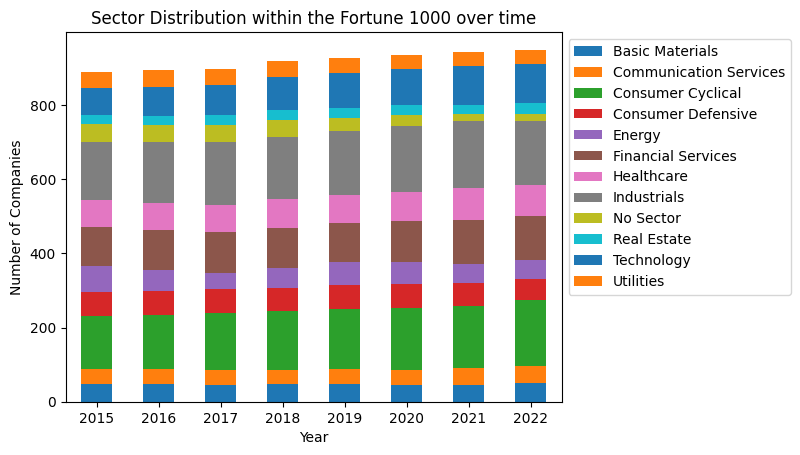

In [ ]:
# create stacked bar chart
# sns.set(style='white')
sector_pivot_df.set_index('year').plot(kind='bar', stacked=True)
 
# labels for x & y axis
plt.xlabel('Year')
plt.ylabel('Number of Companies')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=0)
plt.title('Sector Distribution within the Fortune 1000 over time')
plt.show()

In [ ]:
import plotly.express as px

# compare only three years
sector_count_filtered_df = fortune_sector_df[fortune_sector_df['year'].isin([2016, 2020, 2022])]

# signify if a column will be clipped
sector_count_filtered_df = sector_count_filtered_df.groupby(['sector', 'year']).count().reset_index()[['sector', 'year', 'Rank']]
sector_count_filtered_df = sector_count_filtered_df.rename(columns={'Rank':'count'})

fig = px.sunburst(sector_count_filtered_df, path=['year', 'sector'], values='count',
                  width=512, height=512, title="Sector Distributions within the Fortune 1000 over time")
fig.show()

Below, we plotted the distribution of companies within the Fortune 1000 within only the year 2022. This histogram is a clearer representation than the above two plots for company distributions within a single year. This plot reaffirms some of the insights noted above: 'Consumer Cyclic', 'Industrials', and 'Technology' sectors are the largest ones within the Fortune 1000.

Text(0.5, 1.0, 'Distribution of Company Sectors in the Fortune 1000')

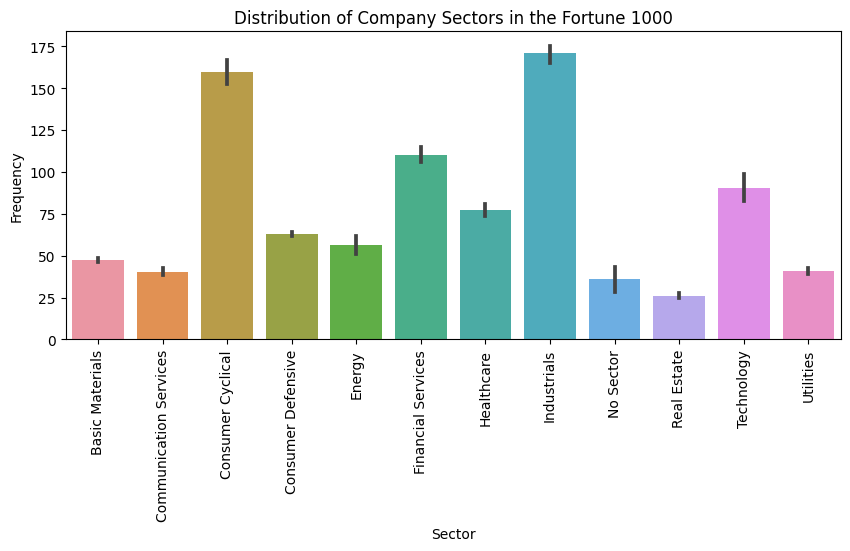

In [ ]:
# MAYBE REMOVE THIS GRAPH
plt.figure(figsize = [10, 4])
sns.barplot(data = sector_count_df, x = 'sector', y = 'count')
plt.xticks(rotation = 90)
plt.ylabel('Frequency')
plt.xlabel('Sector')
plt.title('Distribution of Company Sectors in the Fortune 1000')

### Sector Revenue (2016 vs. 2020 vs. 2022)

Now that we have a sense for how many companies are within each sector in the Fortune 1000, we want to try to understand the revenue distribution of sectors in the Fortune 1000. We also want to gain insight into how this revenue distribution may have changed over time, particularly with respect to the years of 2016 (which we will define as pre-covid), 2020 (during covid), and 2022 (post-covid).

Since we want to visualize the breakdown of the total fortune 1000 revenue into sector subcategories, we created a sunburst chart.

We note from this chart that the overall collective revenue of the Fortune 1000 experienced consistent increases between the 2016 to 2022 time period. Despite the revenue of each sector increasing during this time period, they all seem to have grown at a relatively similar pace as the sector distribution of the overall Fortune 1000 revenue does not seem to have drastically changed.

Additionally, the top companies of every sector stayed the same during this time period. This suggests that COVID did not disrupt the 'top performers' of the Fortune 1000.

It is interesting to note that the 'Healthcare' sector, which consists of a small number of companies as noted above, was also the highest-revenue sector within the Fortune 1000.

In [ ]:
# MOVE IMPORT TO THE TOP???
import plotly.express as px

In [ ]:
# compare only three years
fortune_sector_filtered_df = fortune_sector_df[fortune_sector_df['year'].isin([2016, 2020, 2022])]

fig = px.sunburst(fortune_sector_filtered_df, path=['year', 'sector', 'Company Name'], values='Revenues(millions)',
                  width=812, height=812, title="Overall Revenue Distribution Among Sectors within the Fortune 1000 over time",
                  hover_data=['Revenues(millions)', 'sector', 'year'])
fig.show()

To get a better understanding of the revenue distribution within each sector, we used box plots to display this information between the years of 2016, 2020, and 2022.

From these plots, we see that most sector revenue distributions are positive/right skewed towards higher revenues. This suggests that the bottom 50% of company revenues are concentrated within the lower/left end of the distribution while the top 50% are significantly higher than the median value.

Nearly every sector experienced continual revenue growth between the years of 2016, 2020, and 2022. The main exception to this trend is the Communication Services sector, which has a stark increase in the year 2020 (during the peak of the COVID pandemic) before decreasing in 2022 to return to its 2016 baseline.

In [ ]:
sector_by_year = fortune_sector_df[fortune_sector_df['year'].isin([2016, 2020, 2022])]

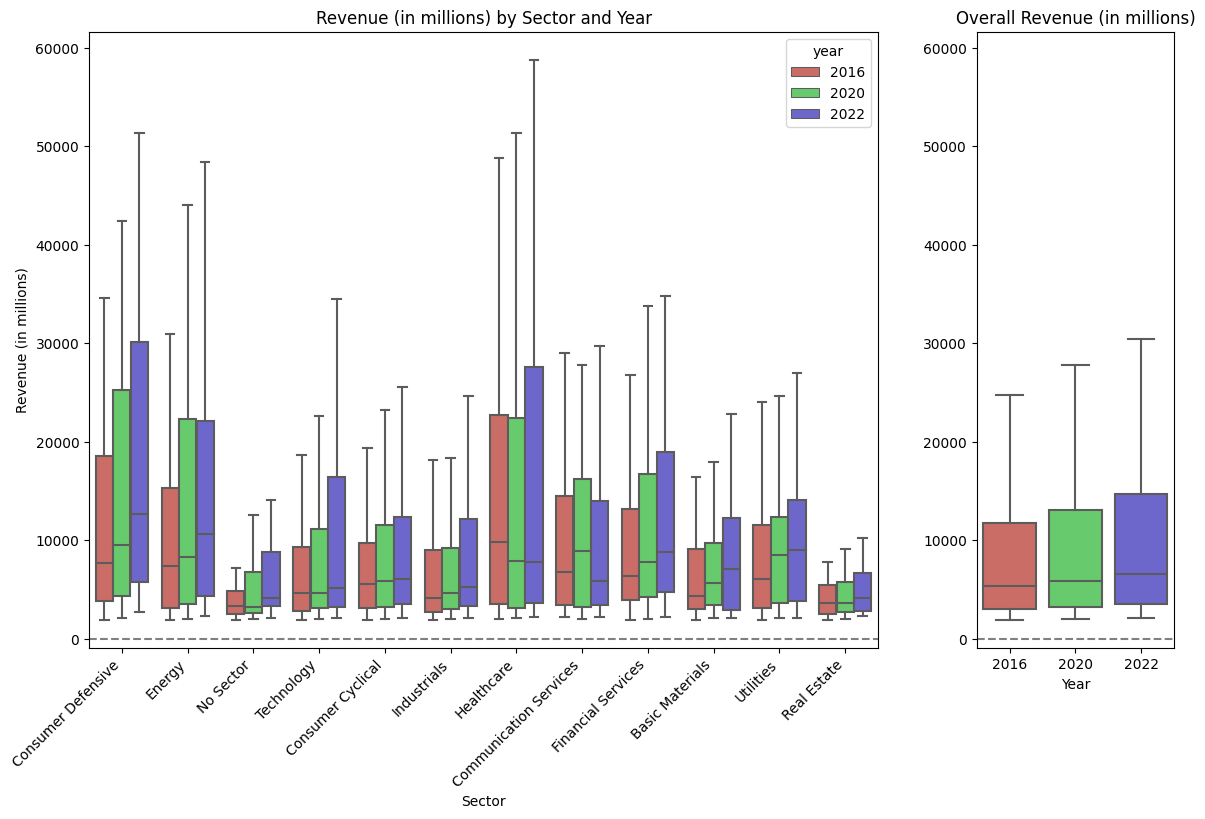

In [ ]:
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(1, 2, width_ratios=[8, 2])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)

# create the first subplot for revenues in specific years
sns.boxplot(x="sector", y="Revenues(millions)", hue="year", data=sector_by_year, ax=ax1, showfliers=False, palette='hls')

# create the second subplot for overall revenue distribution
sns.boxplot(x="year", y="Revenues(millions)", data=sector_by_year, ax=ax2, showfliers=False, palette='hls')

# set title and labels
ax1.set_title("Revenue (in millions) by Sector and Year")
ax1.set_xlabel("Sector")
ax1.set_ylabel("Revenue (in millions)")

ax2.set_title("Overall Revenue (in millions)")
ax2.set_xlabel("Year")
ax2.set_ylabel("")

# rotate x-axis labels
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# add dotted y=0 line
ax1.axhline(y=0, color='gray', linestyle='--')
ax2.axhline(y=0, color='gray', linestyle='--')

# show the plot
plt.show()

In [ ]:
# group by sector
sector_stat_df = fortune_sector_df[['sector', 'Revenues(millions)', 'year', 'Profits(millions)']]
sector_stat_df = sector_stat_df.groupby(['sector', 'year']).sum().reset_index()
sector_stat_df.head()

,sector,year,Revenues(millions),Profits(millions)
0,Basic Materials,2015,385029,11595.0
1,Basic Materials,2016,333168,-2716.0
2,Basic Materials,2017,325339,12385.3
3,Basic Materials,2018,365095,25853.8
4,Basic Materials,2019,417289,29390.8


### Sector Profit (2016 vs. 2020 vs. 2022)

We will now repeat our revenue analysis with sector profits. We want to gain insight into how the profit distribution within the Fortune 1000 may have changed over time, particularly with respect to the years of 2016 (which we will define as pre-covid), 2020 (height of covid), and 2022 (post-covid).

Once again, we want visualize the breakdown of the total Fortune 1000 into sector subcategories, so we created a sunburst chart.

From this plot, we note a dramatic and noticeable increase in overall collective profit within the Fortune 1000 between 2016 and 2022. This suggests that the COVID pandemic did not stunt the performance or profitability of Fortune 1000 companies; it may have in fact helped to increase those profits.

Despite this rapid profit growth, the top companies within every sector stayed the same during this time period. This suggests that COVID did not disrupt the 'top performers' of the Fortune 1000. The sectors of Financial Service and Technology companies experienced the greatest growth in profit.

Overall, there is a much larger difference in profit than in revenue over this time 2016-2022 time frame.

In [ ]:
# signify if a column will be clipped
fortune_sector_filtered_df['Is Clipped'] = fortune_sector_filtered_df['Profits(millions)'].apply(lambda x : 'yes' if x < 0 else 'no') 

fortune_sector_filtered_df['Profits(millions)'] = fortune_sector_filtered_df['Profits(millions)'].clip(lower=0)

In [ ]:
fig = px.sunburst(fortune_sector_filtered_df, path=['year', 'sector', 'Company Name'], values='Profits(millions)',
                  width=812, height=812, title="Overall Profit Distribution Among Sectors within the Fortune 1000 over time",
                  hover_data=['Profits(millions)', 'sector', 'year'])
fig.show()

We used box plots to create an engaging display of the profit distribution within sectors in the years 2016, 2020, and 2022.

We note that most sectors are generally profitable during this time frame (with generally profitable being defined as having the 1st quartile be above the $0 profit mark). The main exception is energy, which had a very negative profitability during 2016.

Overall, the median sector profit and overall median profit of the Fortune 1000 increased from 2016 to 2022. Interestingly, the span (i.e. the length of the whiskers on the box and whisker plots) of most sectors and of the overall Fortune 1000 also increased during this time frame. This suggests a general trend of increased volatility within Fortune 1000 companies that resulted from the COVID-19 pandemic and its aftermath.

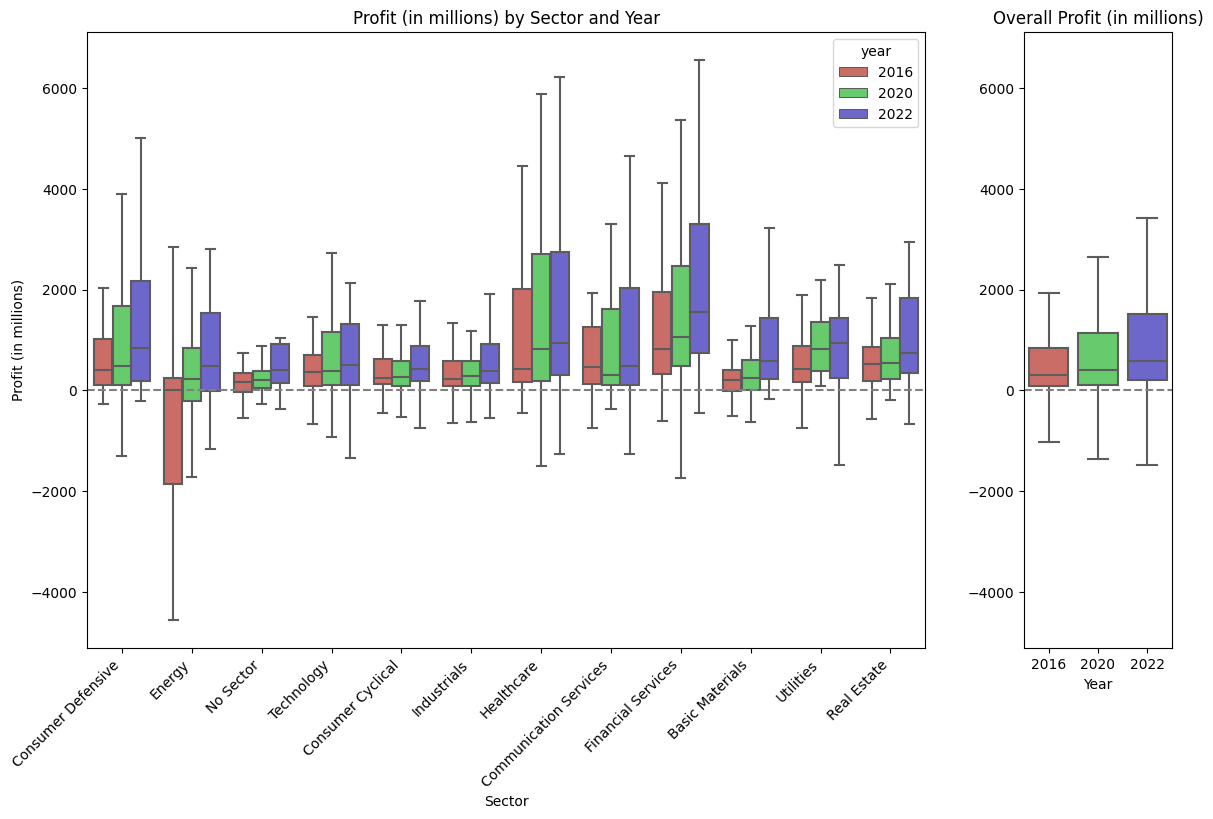

In [ ]:
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(1, 2, width_ratios=[8.5, 1.5])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)

# create the first subplot for revenues in specific years
sns.boxplot(x="sector", y="Profits(millions)", hue="year", data=sector_by_year, ax=ax1, showfliers=False, palette='hls')

# create the second subplot for overall revenue distribution
sns.boxplot(x="year", y="Profits(millions)", data=sector_by_year, ax=ax2, showfliers=False, palette='hls')

# set title and labels
ax1.set_title("Profit (in millions) by Sector and Year")
ax1.set_xlabel("Sector")
ax1.set_ylabel("Profit (in millions)")

ax2.set_title("Overall Profit (in millions)")
ax2.set_xlabel("Year")
ax2.set_ylabel("")

# rotate x-axis labels
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# add dotted y=0 line
ax1.axhline(y=0, color='gray', linestyle='--')
ax2.axhline(y=0, color='gray', linestyle='--')

# show the plot
plt.show()

## Rank Analysis

To analyze changes within the 'status quo' of the Fortune 1000 within the 2016-2022 time frame, we will analyze how the 'status quo' in 2016 (i.e. the rank of companies in 2016) is related to profits and rank changes within the pandemic years.

### Profit Distribution by Rank

We plotted the profit distribution in the years 2015 (pre-covid), 2020 (height of covid), 2022 (post-covid).

We noted from the plot that the profits are positively skewed because of the top quartile. This disparity between the profit of the Top 25 with the rest of the Fortune 1000 increased after the start of COVID in 2020. The remaining quartiles remained largely concentrated around a profit of 0, although there was a slight increase in median profit from 2016 to 2022. In summary, the profit growth of the Top 25 and the Top Quartile of the Fortune 1000 significantly outpaces the profit growth of the rest of the Fortune 1000.

In [ ]:
# add a categorical column for rank
def to_rank_cat(x):
  if x <= 25:
    return 'Top 25'
  if x <= 250:
    return 'First quartile'
  elif x <= 500:
    return 'Second quartile'
  elif x <= 750:
    return 'Third quartile'
  else:
    return 'Fourth quartile'

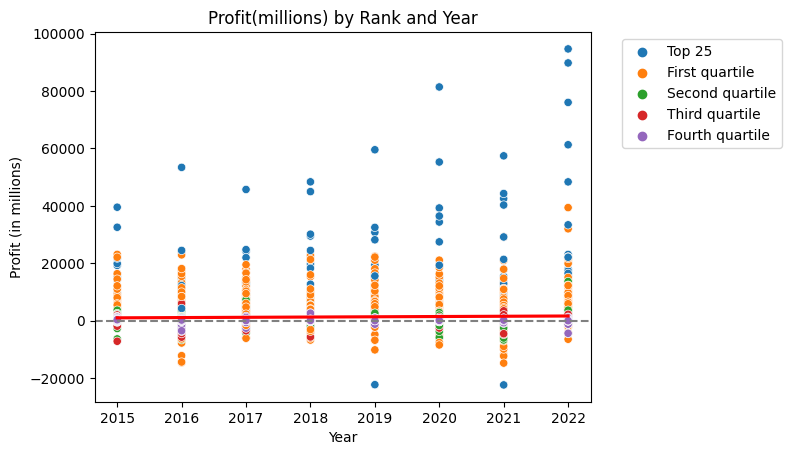

In [ ]:
rank_df = fortune_sector_df
rank_df['Quartile'] = rank_df['Rank'].apply(to_rank_cat)
sns.scatterplot(data=rank_df, x='year', y='Profits(millions)', hue='Quartile')
sns.regplot(data=rank_df, x='year', y='Profits(millions)', scatter=False, color='r')

plt.title("Profit(millions) by Rank and Year")
plt.xlabel("Year")
plt.ylabel("Profit (in millions)")

plt.axhline(y=0, color='gray', linestyle='--')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Change in Rank (2016 vs. 2022)

We will now analyze if the rank change a company experiences within 2016 to 2022 is related to any sort of profit change. We will also see if there is a relationship between a company's Quartile status in 2016 and their ranking changes between 2016 and 2022.

#### Rank Change vs. Profit Change

In this section, we aim to answer the question: is there a relationship between a company's change in profit and its change in Fortune 1000 ranking?

In [ ]:
# make categorical quartile categories
def to_quartile(x):
  if x <= 250:
    return 'First quartile'
  elif x <= 500:
    return 'Second quartile'
  elif x <= 750:
    return 'Third quartile'
  else:
    return 'Fourth quartile'

rank_df['Quartile'] = rank_df['Rank'].apply(to_quartile)

We created a scatterplot graphing company change in profits (in millions) against a company's 2016-2022 rank change.

Overall, higher quartiles (i.e. the first quartile) had larger profit change distributions. Lower quartiles (specifically the fourth quartile), were concentrated around a change in profit of $0. Despite these minimal changes in profit within the lower quartiles, the lower quartiles were also the ones that experienced the largest amount of rank movement (both in the upwards and downwards trending directions).

In [ ]:
s16 = rank_df[rank_df['year']==2016]
s22 = rank_df[rank_df['year']==2022]
rank_diff_df = pd.merge(s16, s22[['Company Name', 'Rank', 'Profits(millions)']], on='Company Name', how='inner').\
                rename(columns={'Rank_x':'Rank 2016', 'Rank_y':'Rank 2022', 'Profits(millions)_x' : 'Profit 2016',
                                'Profits(millions)_y': 'Profit 2022', 'Quartile': 'Quartile (2016)'})

# subtract so that climbing up rank ladder (smaller rank) is positive, dropping ranks is negative
rank_diff_df['Rank Diff'] = rank_diff_df['Rank 2016'] - rank_diff_df['Rank 2022']
rank_diff_df['Profit Diff'] = rank_diff_df['Profit 2022'] - rank_diff_df['Profit 2016']

In [ ]:
# create the scatter plot and add an ordinary least squares regression line
fig = px.scatter(rank_diff_df, x="Profit Diff", y="Rank Diff", color='Quartile (2016)',
                 hover_data=['Company Name', 'sector', 'Quartile (2016)', 'Rank 2016', 'Rank 2022'])

slope, intercept = np.polyfit(rank_diff_df['Profit Diff'], rank_diff_df['Rank Diff'], 1)
x_range = np.array([rank_diff_df['Profit Diff'].min(), rank_diff_df['Profit Diff'].max()])
y_range = intercept + slope * x_range

# Add the overall regression line to the plot
fig.add_trace(go.Scatter(x=x_range, y=y_range, mode='lines', name='Overall Regression Line'))

fig.update_layout(yaxis_title='Change in Rank', xaxis_title='Change in Profit (millions)')

# show the plot
fig.show()

Interestingly, we see that most of the 2016 fourth quartile companies generally experienced little change in profit, either negative or positive, but have a wide range of rank changes (i.e. the rank positions of this quartile are not stable/are constantly changing). This means that for this quartile, change in profit will not be a good predictor of the rank change of a particular company.

If we zoom into the graph, we see that third and second quartile have a wider spread of profit changes, with most companies increasing in profit while still having large amounts of rank changes.

The first quartile has the widest range of profit changes. most companies have an increase in profit, and those wth a large increase in profit are able to maintain their ranks at the top. Those whose profits stayed relatively the same or decreased at all (<= 0) generally saw large decreases in rank

#### Rank Change by Quartile

The median rank change for each quartile is around 0 for the top 50% of the data, but is greater than 0 for the bottom 50% of the data.

In [ ]:
# create a violin plot using plotly
fig = px.violin(rank_diff_df, x='Quartile (2016)', y='Rank Diff', box=True, points="all")
# show the plot
fig.show()

## Relation between Covid Cases, Vaccinations and Sector Stock Prices

Since all of these datasets are time series, we will create a line plot containin all of these datasets to see related trends between covid cases and sector stock data.

In [ ]:
start_date = '2015-01-01'
end_date = '2023-01-01'
extracted_sector_prices_df = sector_stock_close_df[(sector_stock_close_df['date'] > start_date) & (sector_stock_close_df['date'] < end_date)]
extracted_sector_prices_df = extracted_sector_prices_df.reset_index(drop=True)
extracted_sector_prices_df['date'] = pd.to_datetime(extracted_sector_prices_df['date'])
extracted_sector_prices_df.head(3)

,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities,date
0,54.352897,38.724859,78.659277,66.200023,51.695955,60.107051,80.131297,77.714141,79.766205,50.623213,52.659945,2015-01-02
1,52.940127,37.869409,77.404223,65.784729,49.391531,58.762407,79.455983,76.256579,79.314109,49.64813,51.973016,2015-01-05
2,52.416321,37.276663,76.589726,65.233462,48.478853,57.75071,78.849159,74.445648,79.27781,48.857648,51.922074,2015-01-06


NEED TO ADD PADDING TO 2016 WITH 0S FOR THE COVID DATA, THAT WAY WE CAN PLOT FROM 2016 TO 2022.

merge to get data in one df. whatever, data is fine, just fix the legend

In [ ]:
daily_covid_df['Date']

0      2020-01-22
1      2020-01-23
2      2020-01-24
3      2020-01-25
4      2020-01-26
          ...    
996    2022-10-14
997    2022-10-15
998    2022-10-16
999    2022-10-17
1000   2022-10-18
Name: Date, Length: 1001, dtype: datetime64[ns]

In [ ]:
extracted_prices_cases_df = pd.merge(extracted_sector_prices_df, daily_covid_df[['Date', 'tot_cases', 'new_cases_pct_change']],
                                     right_on='Date', left_on='date', how='left')
extracted_prices_cases_df = extracted_prices_cases_df.drop(['Date'], axis=1)
extracted_prices_cases_df = extracted_prices_cases_df.fillna(0)
extracted_prices_cases_df['tot_cases'] = extracted_prices_cases_df['tot_cases'].astype(float)

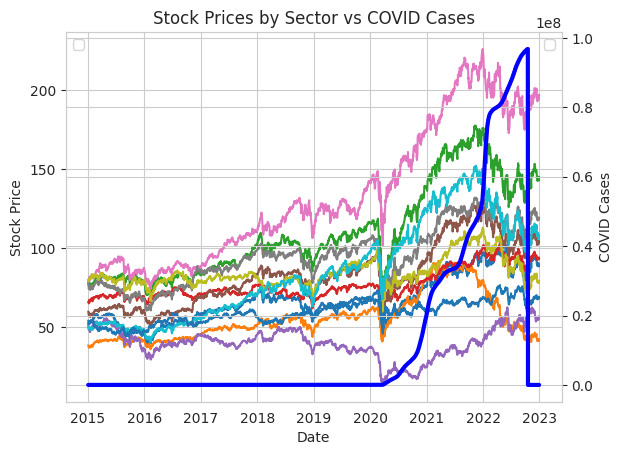

In [ ]:
fig, ax = plt.subplots(figsize = [8, 6])

# Create the first plot
columns = extracted_prices_cases_df.columns[:11]
for column in columns:
  plt.plot(extracted_prices_cases_df['date'], extracted_prices_cases_df[column], label = column)

# Create the second plot with a second y-axis
ax2 = ax.twinx()
plt.plot(extracted_prices_cases_df['date'], extracted_prices_cases_df['tot_cases'], linewidth=5, label = 'COVID-19 Cases')

# set title, labels, and legend
ax.set_title('Stock Prices by Sector vs COVID Cases')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax2.set_ylabel('COVID Cases')

ax.legend(loc = 'best')
ax2.legend(loc='upper left')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

# Section 3: Analysis

Now that we have completed our data preprocessing, loading, and EDA, it's time to use modelling to 

In [ ]:
stock_percentage_changes_df = pd.read_csv('/content/drive/My Drive/CIS 545 Final Project Files/percentage.csv')

## Linear Regression
In this section, we will use a linear regression model to the data to see how COVID-19 has affected stock prices. In particular, we want to fit a linear model,

$s = c^{T}x$,

to the data, where $c$ represents a vector of coefficients to the model, and $x$ represents the features, including the number of COVID cases and deaths, and the number of COVID vaccinations (and booster doses), and $s$ represents the percentage change in stock prices, aggregating by company sector.

#### Step One: Obtain the stock percentage changes
In this dataframe, we have each individual sector as a column, as well as dates as a column. We already computed this dataframe in our preprocessing.

In [ ]:
stock_percentage_changes_transpose_df = stock_percentage_changes_df.transpose()
stock_percentage_changes_transpose_df = stock_percentage_changes_transpose_df.reset_index(names = ['Ticker'])
stock_percentage_changes_transpose_df.head()

dates = stock_percentage_changes_df['Date'].apply(pd.to_datetime)

final_companies_df = pd.read_csv('/content/drive/MyDrive/CIS 545 Final Project Files/company_tickers.csv')

joined_sectors_df = final_companies_df.merge(stock_percentage_changes_transpose_df, left_on = 'ticker', right_on = 'Ticker', how = 'right')
joined_sectors_df.head()

,company_name,ticker,sector,Ticker,0,1,2,3,4,5,...,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081
0,NaN,NaN,NaN,Date,2015-01-02 00:00:00,2015-01-05 00:00:00,2015-01-06 00:00:00,2015-01-07 00:00:00,2015-01-08 00:00:00,2015-01-09 00:00:00,...,2023-03-28 00:00:00,2023-03-29 00:00:00,2023-03-30 00:00:00,2023-03-31 00:00:00,2023-04-03 00:00:00,2023-04-04 00:00:00,2023-04-05 00:00:00,2023-04-06 00:00:00,2023-04-10 00:00:00,2023-04-11 00:00:00
1,Agilent Technologies,A,Healthcare,A,-1.505583,-1.289684,-1.58252,0.455466,1.615302,-1.0,...,0.067913,-0.074648,-0.576624,2.171346,0.320188,-0.028928,0.254095,0.014495,0.465861,-0.252028
2,Alcoa,AA,Basic Materials,AA,0.063019,-4.347828,0.332894,1.178013,1.53256,0.499069,...,0.695649,-0.871672,0.384615,1.405766,-1.856205,-2.654437,-0.979406,0.102252,1.583245,0.271472
3,Vectren,AA,Basic Materials,AA,0.063019,-4.347828,0.332894,1.178013,1.53256,0.499069,...,0.695649,-0.871672,0.384615,1.405766,-1.856205,-2.654437,-0.979406,0.102252,1.583245,0.271472
4,American Airlines Group,AAL,Industrials,AAL,-0.681649,-0.901228,-2.266445,-0.693149,0.336575,-3.074339,...,0.503233,1.198872,-0.618133,0.95825,-0.688708,-2.680415,-1.209104,0.430111,1.216023,0.703231


In [ ]:
aggregated_sectors_df = joined_sectors_df.groupby('sector', as_index = False).mean()
aggregated_sectors_df

<ipython-input-230-9978a8adb48c>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-230-9978a8adb48c>:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



,sector,0,1,2,3,4,5,6,7,8,...,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081
0,Basic Materials,-0.004892,-2.184700,-1.503075,0.043363,1.817133,-0.843180,-0.082745,-1.790705,0.375629,...,0.618192,-0.324592,-0.836383,1.286436,-0.199852,-2.474924,0.341451,0.442203,1.808120,0.408322
1,Communication Services,-1.203801,-1.873902,-1.818508,-0.368960,0.963934,-0.572591,-0.386413,-0.397340,-0.203754,...,0.772906,0.261130,-0.656136,2.019841,-0.478840,-1.721306,-0.180437,1.201557,2.314164,0.905187
2,Consumer Cyclical,-1.208350,-0.678158,-1.291398,1.320959,0.601272,-1.080473,-0.170608,-1.542588,0.652656,...,0.593661,0.096722,-0.615432,1.521978,0.214023,-1.694263,-1.146842,-0.441120,1.818543,0.773787
3,Consumer Defensive,-0.896168,-0.505258,-1.025058,1.133967,1.161589,-1.042697,-0.728263,-0.515575,0.883430,...,0.468424,-0.080878,-0.067873,0.503391,0.707686,-1.427166,-0.101774,0.778902,0.732879,0.587617
4,Energy,1.429619,-3.219826,-1.646224,-1.263110,1.326709,-0.431078,-2.072515,-1.192155,1.501184,...,2.011421,-0.169297,-1.043984,0.710490,-0.073355,-2.726318,1.522477,-1.218959,0.831655,0.436824
5,Financial Services,-0.645108,-1.543726,-1.948764,0.312722,0.779766,-1.475012,-1.000718,-0.866549,-0.092128,...,-0.322526,2.258001,-1.607552,0.537993,-0.322488,-2.026627,0.979824,0.193438,0.783945,0.469936
6,Healthcare,-0.603548,-0.414974,-1.063890,1.194396,1.054088,-0.644759,-1.007188,-0.841568,0.696189,...,-0.259475,-0.043896,-0.096083,0.742143,0.267320,-0.216303,1.282450,-0.041884,0.902716,0.627986
7,Industrials,-0.778501,-1.755467,-1.641079,-0.304352,1.066232,-1.156206,-0.880602,-0.934333,0.405825,...,0.533450,0.245660,-0.562047,0.970121,0.154609,-3.058756,-0.850279,-0.373470,2.024276,0.476873
8,Real Estate,0.693235,0.310322,-0.242979,0.759331,0.551541,-0.396291,0.136672,-1.723007,1.202488,...,0.866325,1.123010,0.080449,1.830904,-0.892970,-1.180858,-0.083984,0.737204,1.326439,0.890771
9,Technology,-0.892612,-1.292274,-1.712000,0.337724,1.307943,-0.603713,-1.075378,-0.755689,0.452181,...,-0.091687,1.142477,-0.221261,1.733394,0.026056,-1.822653,-0.665546,0.443153,1.635776,-0.087582


#### Step Two: Filter dates based on the start dates and end dates of the COVID data.

First, we can inspect the COVID and vaccination dataframes to see their earliest and latest date.

In [ ]:
daily_covid_df['Date'] = daily_covid_df['Date'].apply(pd.to_datetime) ## remove later
# Determine the minimum and maximum dates for analysis
earliest_covid_date = daily_covid_df['Date'].min()
earliest_vaccine_date = daily_vaccinations_df['Date'].min()

print('The earliest COVID cases date is', earliest_covid_date)
print('The earliest vaccination date is', earliest_vaccine_date)

The earliest COVID cases date is 2020-01-01 00:00:00
The earliest vaccination date is 2020-01-01 00:00:00


It appears that the COVID cases have an earlier date, starting in January 2020, whereas the vaccinations started in December 2021. Here, we have a few possible approaches:
1. Have all of the data for COVID cases and stock prices start from the latest date in December 2021. This approach has the disadvantage of having too few data points for linear regression, and also does not adequately reflect the massive drop in stock prices at the beginning of the pandemic before the vaccine was released.
2. Have all of the data for COVID cases and stock prices start from the earlier date in January 2020, imputing zero values for vaccinations between January 2020 and December 2021.
3. Start all of the data from January 2019, which will incorporate some stock data from before the pandemic beganm and impute zero values for vaccinations between January 2019 and December 2021, and imputing zero values for COVID cases between January 2019 and January 2020.

We decided to take approach 2, in order to keep the data relevant to the COVId-19 pandemic, while also keeping as many datapoints as possible (in other words, approach 1 risks removing too much data, while approach 3 risks "diluting" the data we intend to perform the analysis on).

In [ ]:
start_date = pd.to_datetime('01/01/2020')

## Value imputation based on the data that is missing. We impute all zeros.
for date in pd.date_range(start=start_date, end=earliest_covid_date):
  daily_covid_df = pd.concat([daily_covid_df, pd.DataFrame({'Date': date, 
                                                      'tot_cases': [0], 
                                                      'new_case': [0], 
                                                      'tot_death': [0], 
                                                      'new_death': [0], 
                                                      'tot_cases_pct_change': [0], 
                                                      'tot_death_pct_change': [0], 
                                                      'new_death_pct_change': [0], 
                                                      'new_cases_pct_change': [0]})])

for date in pd.date_range(start=start_date, end=earliest_vaccine_date):
  daily_vaccinations_df = pd.concat([daily_vaccinations_df, pd.DataFrame({'Date': date, 
                                                                    'Dose1_pop': [0], 
                                                                    'Booster_pop': [0], 
                                                                    'Dose1_pct': [0], 
                                                                    'Booster_pct': [0]})])

daily_covid_df = daily_covid_df.sort_values('Date').reset_index()
daily_covid_df = daily_covid_df.drop(columns = 'index')
daily_vaccinations_df = daily_vaccinations_df.sort_values('Date').reset_index()
daily_vaccinations_df = daily_vaccinations_df.drop(columns = 'index')

#### Step Three: Groupby sector
Now, the objective is to take all of these tickers and classify their sector. This way we can compute average percentage changes per sector. We can join our data on ```final_companies_df``` to get the sectors for each ticker, and then aggregate.

In [ ]:
#stock_percentage_changes_df = pd.read_csv('/content/drive/My Drive/CIS 545 Final Project Files/percentage.csv')

Later on, we will need to access these dates to perform the join between the COVID/vaccinations data and the stock percentage changes data on date. This step is to save the column of dates so that we can add it back to the ```stock_percentage_changes_df``` (renamed to ```aggregated_sectors_df```) for each sector when we are ready.

In [ ]:
## Access dates; we will be using this series to add back the dates to the groupby.
dates = stock_percentage_changes_df['Date'].apply(pd.to_datetime)

#### Step Four: Perform the analyses for each sector
Now that we have stock percentage changes, vaccinations per day, deaths per day, and cases per day, the last step is to transpose again to get each of these into column form, and then to fit a linear model to each of these variables.

First, we obtain a list of each sector, and then we can perform a linear model on each one, saving the coefficients and putting them into a dataframe.

In [ ]:
# Getting list of sectors
sectors = aggregated_sectors_df['sector'].tolist()
print(sectors)

['Basic Materials', 'Communication Services', 'Consumer Cyclical', 'Consumer Defensive', 'Energy', 'Financial Services', 'Healthcare', 'Industrials', 'Real Estate', 'Technology', 'Utilities']


For each of these sectors, we need to:
1. Extract the stock data as a column
2. Join it on the data for the COVID-19 data, combining the stock percentages data back with the date column
3. Fit a linear model to the data
4. Save the coefficients

In [ ]:
stock_percentage_changes_df

,Date,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABG,ABM,...,XPO,XRAY,XRX,YELL,YUM,ZBH,ZBRA,ZEUS,ZION,ZTS
0,2015-01-02 00:00:00,-1.505583,0.063019,-0.681649,-1.423692,-1.849356,0.687648,-0.165546,-0.652827,-0.941096,...,-1.359558,-0.383658,-0.936599,-2.514335,-1.484209,-1.418439,-0.718038,2.122911,-1.325424,-0.345140
1,2015-01-05 00:00:00,-1.289684,-4.347828,-0.901228,-1.074791,-1.883831,-1.297708,-0.421891,-2.206949,0.671848,...,-2.525376,-0.712358,-1.392965,-4.172336,-2.112971,2.438382,-0.456391,-9.041094,-3.542331,-0.462430
2,2015-01-06 00:00:00,-1.582520,0.332894,-2.266445,-0.127745,-0.262811,-1.965865,0.044376,-0.178519,-0.348305,...,-4.187683,-1.279317,-1.484778,-6.156021,-1.891822,-1.160806,-0.642367,-4.156630,-3.713236,-1.205100
3,2015-01-07 00:00:00,0.455466,1.178013,-0.693149,1.338748,0.513063,3.654949,1.099143,2.082197,1.077509,...,-0.209312,1.713064,0.825209,-4.856291,1.916304,2.134252,1.754391,-7.249999,0.075702,1.186043
4,2015-01-08 00:00:00,1.615302,1.532560,0.336575,-1.371208,2.435225,-0.777592,0.490522,-0.369489,0.375045,...,-0.337838,1.903312,2.144972,2.156058,0.946499,0.756049,0.915324,7.444672,0.411980,-1.273742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,2023-04-04 00:00:00,-0.028928,-2.654437,-2.680415,-1.108395,-0.582234,-0.454798,0.536703,-3.783221,-3.612583,...,-4.476190,-0.915333,-3.430076,-4.591838,-0.873748,-0.358316,-1.092530,-6.520499,-5.005146,-0.191166
2078,2023-04-05 00:00:00,0.254095,-0.979406,-1.209104,-0.652893,-0.594883,0.500002,2.067451,-3.052791,0.860863,...,-0.100471,0.848324,-0.895935,-5.820107,-0.053020,0.171381,-2.700343,-0.290222,3.245581,0.389218
2079,2023-04-06 00:00:00,0.014495,0.102252,0.430111,0.507995,1.372906,0.466418,-0.982139,-0.672319,0.758451,...,-1.018401,-0.327697,-0.277200,1.117317,-0.037827,0.451047,1.002426,-0.351091,3.122805,0.398169
2080,2023-04-10 00:00:00,0.465861,1.583245,1.216023,0.249815,0.377897,-0.265913,0.319565,1.718964,0.503551,...,4.668222,1.195618,2.288488,3.867406,-0.342073,-0.155833,1.560603,3.275286,2.540342,1.768911


In [ ]:
i = 0
R_values = []
model_values = []

for current_sector in sectors:
  # Filter to sector and transpose to column
  sector_row = aggregated_sectors_df[aggregated_sectors_df['sector'] == current_sector]
  sector_row = sector_row.drop('sector', axis = 1)
  sector_col = sector_row.transpose()
  sector_col = pd.DataFrame(data = sector_col)
  sector_col['Date'] = dates

  # Merging
  sector_col = sector_col.merge(daily_covid_df, on = 'Date', how = 'inner')
  sector_col = sector_col.merge(daily_vaccinations_df, on = 'Date', how = 'inner')
  sector_col = sector_col.rename(columns = {i: 'Stock Price'})
  sector_col = sector_col[sector_col['Date'] < pd.to_datetime('05/01/2022')] ##Remove this test code later

  sector_col.sort_values('Date', ascending = True).head()

  ## Filtering out unnecessary rows
  linear_df = sector_col[['Stock Price', 'tot_cases', 'new_case', 'tot_death', 
                          'new_death', 'tot_cases_pct_change', 
                          'tot_death_pct_change', 'Dose1_pop', 'Booster_pop', 
                          'Dose1_pct', 'Booster_pct',]] ## Excluded new cases and new deaths percent change

  model = LinearRegression()

  ## Fitting the model to the data and testing with the R^2 value and RMSE.
  ## TO-DO: Fix this to HW 4
  model.fit(X = linear_df[['tot_cases', 'new_case', 'tot_death', 
                          'new_death',
                          'Dose1_pop', 'Booster_pop', 'Dose1_pct', 'Booster_pct']],
            y = linear_df['Stock Price'])

  R_values.append(model.score(X = linear_df[['tot_cases', 'new_case', 'tot_death', 
                          'new_death',
                          'Dose1_pop', 'Booster_pop', 'Dose1_pct', 'Booster_pct']],
            y = linear_df['Stock Price']))

  model_values.append(model.coef_)
  i += 1

model_values = np.array(model_values)

In [ ]:
print('The R^2 values are', R_values)

The R^2 values are [0.011135914060868779, 0.009704612575800575, 0.010782970673843373, 0.004149754291786989, 0.018581191918362605, 0.003607583615932497, 0.010711929133566445, 0.007364608283100815, 0.00948040699264563, 0.0076130089722380445, 0.006430511844809472]


It is easiest to show the model coefficients through a correlation plot:

Text(0.5, 1.0, 'Colourmap Depicting Linear Model Coefficients')

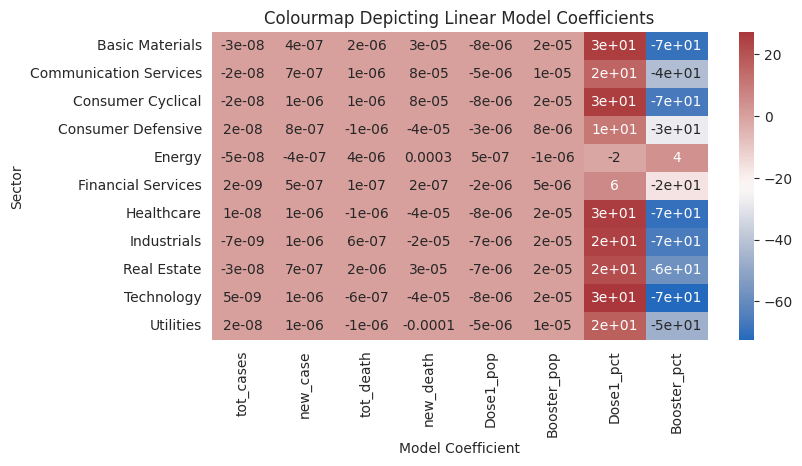

In [ ]:
plt.figure(figsize = [8, 4])
sns.heatmap(data = model_values, 
            xticklabels = ['tot_cases', 'new_case', 'tot_death', 'new_death', 
                           'Dose1_pop', 'Booster_pop', 'Dose1_pct', 'Booster_pct'],
            yticklabels = sectors,
            annot = True,
            cmap = 'vlag',
            fmt = ".0g")
plt.ylabel('Sector')
plt.xlabel('Model Coefficient')

plt.title('Colourmap Depicting Linear Model Coefficients')

Here, we encounter an interesting result. It seems that the $R^2$ values for all of these linear models do not show a significant correlation between COVID cases, deaths, and vaccinations and stock price percentage chages for any sector. This warrants some additional EDA. Below, we graph the stock prices for Delta Airlines (just to give an example) between 2007 and 2024.

Text(0, 0.5, 'Stock Price ($)')

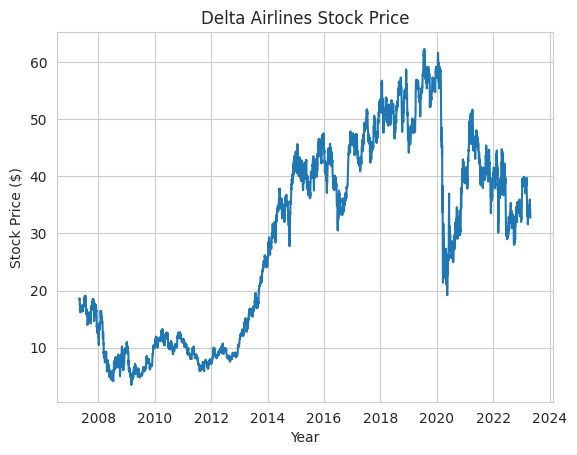

In [ ]:
df = yf.Ticker('DAL').history(period="max")
df = df.reset_index(level=0)
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()
plt.plot(df['Date'], df['Close']) ## Tin make a title for this
plt.title('Delta Airlines Stock Price')
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')

Based on this EDA, it seems that the main drop in stock prices occurred **before** 2020, at least for Delta Airlines. The COVID-19 dataset does not capture this period of time! Therefore, it is likely that the drop in stock prices was due to **fears** of the pandemic, and not necessarily the pandemic itself.

#### Step Give: Repeat the analysis using PCA:
Now, we can try and perfrom linear regression using PCA. All of the code is very similar, except that we first have to apply PCA:

In [ ]:
i = 0
R_values = []
model_values = []
n = 8

for current_sector in sectors:
  # Determine the number components to include (TO-DO)

  # Instantiate PCA Model
  pca = PCA(n_components = n)

  # Filter to sector and transpose to column
  sector_row = aggregated_sectors_df[aggregated_sectors_df['sector'] == current_sector]
  sector_row = sector_row.drop('sector', axis = 1)
  sector_col = sector_row.transpose()
  sector_col = pd.DataFrame(data = sector_col)
  sector_col['Date'] = dates

  # Merging
  sector_col = sector_col.merge(daily_covid_df, on = 'Date', how = 'inner')
  sector_col = sector_col.merge(daily_vaccinations_df, on = 'Date', how = 'inner')
  sector_col = sector_col.rename(columns = {i: 'Stock Price'})
  sector_col = sector_col[sector_col['Date'] < pd.to_datetime('05/01/2022')] ##Remove this test code later

  sector_col.sort_values('Date', ascending = True).head()

  ## Filtering out unnecessary rows
  linear_df = sector_col[['Stock Price', 'tot_cases', 'new_case', 'tot_death', 
                          'new_death', 'tot_cases_pct_change', 
                          'tot_death_pct_change', 'Dose1_pop', 'Booster_pop', 
                          'Dose1_pct', 'Booster_pct',]] ## Excluded new cases and new deaths percent change
  
  ## Performing the PCA
  x = linear_df[['tot_cases', 'new_case', 'tot_death', 
                          'new_death',
                          'Dose1_pop', 'Booster_pop', 'Dose1_pct', 'Booster_pct']]
  y = linear_df[['Stock Price']]

  ## Fit standard scaling to the data and fit the transform
  scaler = StandardScaler()
  x_scaled = scaler.fit_transform(x)
  pca.fit_transform(x_scaled)
  x_pca = pca.transform(x_scaled)

  model = LinearRegression()
  model.fit(X = x_pca, y = y)

  ## Fitting the model to the data and testing with the R^2 value and RMSE.
  ## TO-DO: Fix this to HW 4  
  R_values.append(model.score(X = x_pca, y = y))

  model_values.append(np.reshape(np.array(model.coef_),8))
  i += 1

model_values = np.array(model_values)
print(model_values)

[[ 8.49754904e-03  2.58830025e-02 -3.92756065e-02 -1.16180452e-01
   3.75626403e-02  1.06125700e+00 -2.01530831e+01 -1.48704779e+03]
 [-4.09528928e-03  9.81924833e-02  6.76299453e-03 -5.16882430e-02
   3.49844021e-02  6.69850915e-01 -6.04808687e+00 -9.08695753e+02]
 [-1.14255793e-02  8.54967618e-02  8.97132906e-03 -8.59849783e-02
   1.16750722e-01  9.97084796e-01  1.52584971e+01 -1.45822734e+03]
 [ 1.71656462e-03  5.96351095e-03 -1.96900919e-02  1.08024388e-02
   1.14436555e-02 -4.74772872e-01  7.74624231e+00 -6.12588880e+02]
 [ 6.96966915e-02  1.72326347e-01  5.01831431e-02 -1.52591706e-01
   1.35481144e-01  1.83279567e+00 -2.76767474e+00  8.78909820e+01]
 [-1.79323498e-02  5.11326814e-02  2.04854959e-02 -7.06347876e-03
   1.07395227e-01 -2.15568338e-03 -2.90948970e+00 -3.53755920e+02]
 [-6.74337980e-03  9.58801565e-03 -2.80865911e-02 -2.01369244e-02
  -6.70666909e-02 -2.64485866e-01 -4.95639861e+00 -1.51105294e+03]
 [-6.51386162e-03  3.31267512e-02 -5.02941490e-03 -3.79991715e-02
   

In [ ]:
print('The R^2 values are', R_values)

The R^2 values are [0.011135914060876773, 0.00970461257580768, 0.010782970673848147, 0.004149754291791541, 0.018581191918362827, 0.003607583615933607, 0.010711929133572773, 0.007364608283105589, 0.00948040699264563, 0.007613008972245483, 0.006430511844809694]


It is easiest to show the model coefficients through a correlation plot:

Text(0.5, 1.0, 'Colourmap Depicting Linear Model Coefficients')

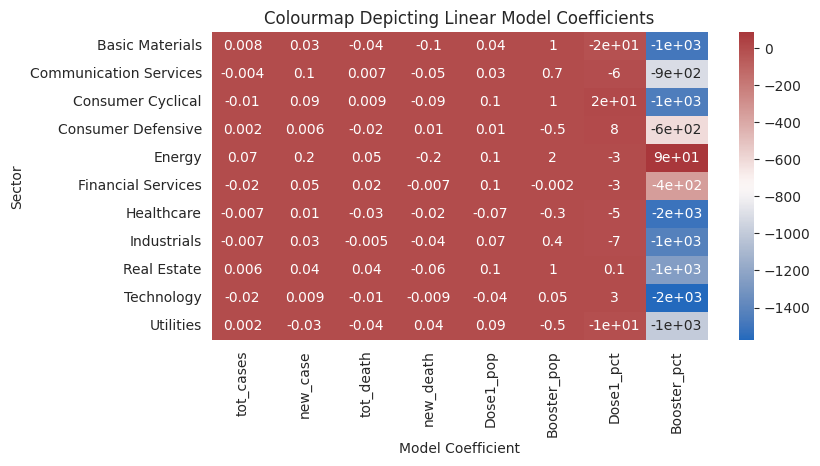

In [ ]:
plt.figure(figsize = [8, 4])
sns.heatmap(data = model_values, 
            xticklabels = ['tot_cases', 'new_case', 'tot_death', 'new_death', 
                           'Dose1_pop', 'Booster_pop', 'Dose1_pct', 'Booster_pct'],
            yticklabels = sectors,
            annot = True,
            cmap = 'vlag',
            fmt = ".0g")
plt.ylabel('Sector')
plt.xlabel('Model Coefficient')

plt.title('Colourmap Depicting Linear Model Coefficients')

Similarly to the code above, instead of doing linear regression on the daily percentage change, we do linear regression on the average Close price for each sector. This does shows signficant R^2, despite the variables themselves do not predict the target label as well as expected, as indicated by the model coeficients

### Linear regression for stock close price df for all the sector

Training on Financial Services
Coefficient of determination (R^2): 0.84
My mean squared error is 54.125770876637816
Training on Consumer Cyclical
Coefficient of determination (R^2): 0.89
My mean squared error is 79.86057335188491
Training on Consumer Defensive
Coefficient of determination (R^2): 0.90
My mean squared error is 11.82138407675733
Training on Healthcare
Coefficient of determination (R^2): 0.91
My mean squared error is 74.29186665954977
Training on Energy
Coefficient of determination (R^2): 0.90
My mean squared error is 15.70273246400773
Training on Technology
Coefficient of determination (R^2): 0.87
My mean squared error is 51.164140008842274
Training on Industrials
Coefficient of determination (R^2): 0.81
My mean squared error is 54.20578262369253
Training on Real Estate
Coefficient of determination (R^2): 0.69
My mean squared error is 42.40870034538453
Training on Utilities
Coefficient of determination (R^2): 0.61
My mean squared error is 12.354157905945984
Training on Ba

Text(0.5, 1.0, 'Sector stock prices vs. COVID data coefficients')

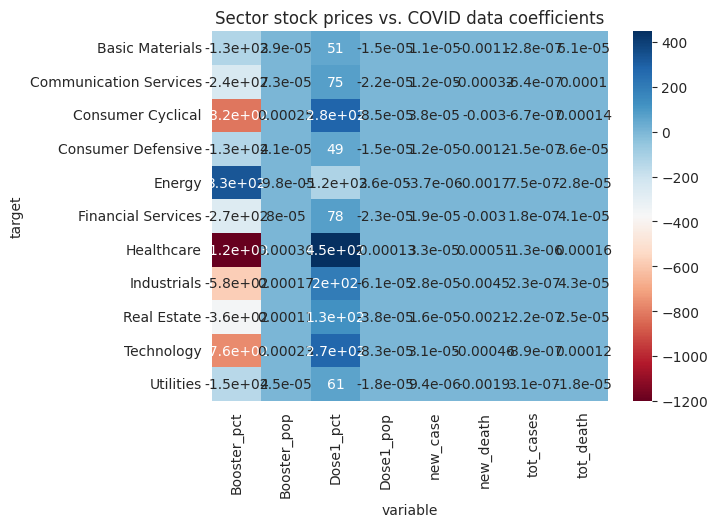

In [ ]:

sector_stock_prices_df_for_merge = sector_stock_close_df.rename({'date': 'Date'}, axis=1)
temp =  pd.merge(daily_vaccinations_df, sector_stock_prices_df_for_merge, how='inner')
temp1 =  pd.merge(daily_covid_df, temp, how='inner')
temp1.columns
list_of_sector = list(set(sector_stock_close_df.columns) - set(['date']))
X_column_names = ['tot_cases', 'new_case', 'tot_death', 'new_death', 'Dose1_pop', 'Booster_pop', 'Dose1_pct', 'Booster_pct']
columns_to_take = X_column_names + list_of_sector
data = temp1[columns_to_take]
data
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score



targets = list_of_sector
coefficients_list = []

for sector in list_of_sector:
  features = data[X_column_names]  # features
  target = data[sector]

  X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


  model = LinearRegression()

  # fit the model to the data
  model.fit(X_train, y_train)
  
  coefficients = pd.DataFrame({'variable': X_column_names, 'coefficient': model.coef_})
  coefficients['target'] = sector
  coefficients_list.append(coefficients)

  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)



  #print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
  print(f'Training on {sector}')
  print('Coefficient of determination (R^2): %.2f' % r2_score(y_test, y_pred))
  print(f'My mean squared error is {mse}')

coefficients_df = pd.concat(coefficients_list)

# create a pivot table for the heatmap
heatmap_data = coefficients_df.pivot(index='target', columns='variable', values='coefficient')

# create the heatmap
ax = sns.heatmap(heatmap_data, annot=True, cmap='RdBu')
ax.set_title('Sector stock prices vs. COVID data coefficients')


In [ ]:
X_train_scaled = scaler.fit_transform(data[X_column_names])
pca = PCA()
pca.fit(X_train_scaled)
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(explained_variance_ratios)

We graph the accmuluative sum of variance and found out that three components of the covid data covered most of the data complexity.

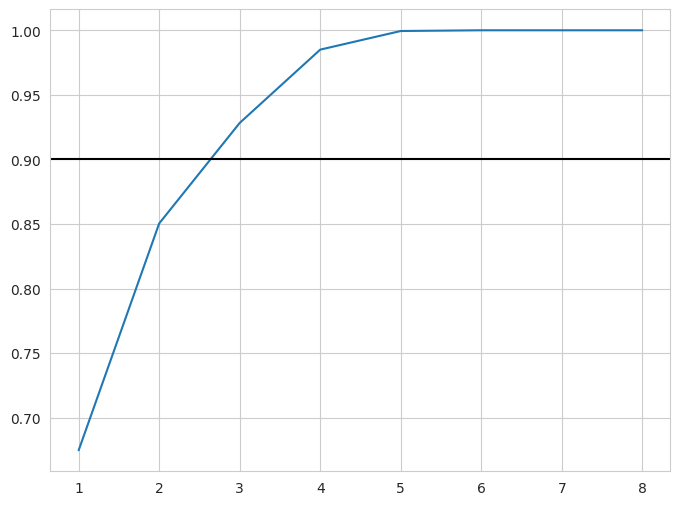

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(1, len(cum_evr) +1),cum_evr)

plt.axhline(y=0.9, color='black')

We train the linear regression on scaled and PCA data. This shows that we achieves worse but expected result because the dimension of the data is reduced.

In [ ]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA


for sector in list_of_sector:
  features = data[X_column_names]  # features
  target = data[sector]

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(features)

  # Apply PCA on the scaled data
  pca = PCA(n_components=3)
  X_pca = pca.fit_transform(X_scaled)

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X_pca, target, test_size=0.2, random_state=42)

  # Train a linear regression model on the training data
  reg = LinearRegression()
  reg.fit(X_train, y_train)

  # Make predictions on the test data
  y_pred = reg.predict(X_test)

  # Evaluate the performance of the model
  score = reg.score(X_test, y_test)
  print("R^2 score:", score)

R^2 score: 0.7846461070833649
R^2 score: 0.7362891840523578
R^2 score: 0.8656754980906504
R^2 score: 0.8467255741303398
R^2 score: 0.8770073996086116
R^2 score: 0.732111780306794
R^2 score: 0.7245657076974246
R^2 score: 0.6579283888858156
R^2 score: 0.5941782184562048
R^2 score: 0.8085849367241208
R^2 score: 0.6617695221924269


This analysis using PCA confirms what we had above - there is no strong relationship between daily percent changes and COVID cases.

## LSTM Anomaly Detection
In this section, we will use an LSTM ("Long Short Term Memory") model to detect anomalies in stock price data. This will allow us to identify whether an anomaly was detecting in the stock prices, as well as when these anomalies occurred. **[Tin complete this]**


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns
import yfinance as yf
from tensorflow import keras


In [ ]:
sector_list_ml = list(sector_stock_close_df.columns)

anamoly_dates_dict = {}

In [ ]:
# convert this to some kind of a sliding window
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

def LSTM_autoencoder_anomaly_detection(time_steps):
  for current_sector in sector_list_ml:
    cut_off_date = '2019-01-01'
    test_end_date = '2021-12-31'

    train, test = sector_stock_close_df.loc[sector_stock_close_df['date'] < cut_off_date], sector_stock_close_df.loc[(sector_stock_close_df['date'] > cut_off_date) & (sector_stock_close_df['date'] <= test_end_date)]


    scaler = StandardScaler()
    scaler = scaler.fit(train[[current_sector]])

    train[current_sector] = scaler.transform(train[[current_sector]])
    test[current_sector] = scaler.transform(test[[current_sector]])


    # create sequence of data as appropriate input to the ML model
    X_train, y_train = create_sequences(train[[current_sector]], train[current_sector], time_steps)
    X_test, y_test = create_sequences(test[[current_sector]], test[current_sector], time_steps)

    X_train = X_train.astype(np.float32)
    y_train = y_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_test = y_test.astype(np.float32)


    # NOT MY CODE 
    # https://towardsdatascience.com/time-series-of-price-anomaly-detection-with-lstm-11a12ba4f6d9
    # https://github.com/bnsreenu/python_for_microscopists/blob/master/180_LSTM_encoder_decoder_anomaly_GE.py

    model = Sequential()
    # encoder part
    model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=0.2))
    model.add(RepeatVector(X_train.shape[1]))
    # decoder part
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(rate=0.2))
    model.add(TimeDistributed(Dense(X_train.shape[2])))
    model.compile(optimizer='adam', loss='mae')
    model.summary()


    # fit model
    history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)


    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend();

    model.evaluate(X_test, y_test)

    X_train_pred = model.predict(X_train, verbose=0)
    train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
    threshold = np.max(train_mae_loss)

    X_test_pred = model.predict(X_test, verbose=0)
    test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

    import plotly.graph_objects as go

    test_score_df = pd.DataFrame(test[time_steps:])
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = threshold
    # whatever datapoint above the predetermined threshold is an anamoly
    test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
    test_score_df['Close'] = test[time_steps:][current_sector]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test_score_df['date'], y=test_score_df['loss'], name='Test loss'))
    fig.add_trace(go.Scatter(x=test_score_df['date'], y=test_score_df['threshold'], name='Threshold'))
    fig.update_layout(showlegend=True, title=f'Test loss vs. Threshold for {current_sector}')
    fig.show()

    anamoly_date = list(test_score_df[test_score_df['anomaly'] == True]['date'])
    anamoly_dates_dict[current_sector] = anamoly_date
    


<ipython-input-223-e295debf0681>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-223-e295debf0681>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

<ipython-input-223-e295debf0681>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-223-e295debf0681>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_5 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

<ipython-input-223-e295debf0681>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-223-e295debf0681>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_3 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_7 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_7 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

<ipython-input-223-e295debf0681>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-223-e295debf0681>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_4 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_9 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

<ipython-input-223-e295debf0681>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-223-e295debf0681>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_5 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_11 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_11 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

<ipython-input-223-e295debf0681>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-223-e295debf0681>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_6 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_13 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_13 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_6 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

<ipython-input-223-e295debf0681>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-223-e295debf0681>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_7 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_15 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_15 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

<ipython-input-223-e295debf0681>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-223-e295debf0681>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_8 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_17 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_17 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_8 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

<ipython-input-223-e295debf0681>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-223-e295debf0681>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_9 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_19 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_19 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_9 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

<ipython-input-223-e295debf0681>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-223-e295debf0681>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_10 (RepeatVec  (None, 30, 128)          0         
 tor)                                                            
                                                                 
 lstm_21 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_21 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 1)            129       
 stributed)                                          

<ipython-input-223-e295debf0681>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-223-e295debf0681>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_11 (RepeatVec  (None, 30, 128)          0         
 tor)                                                            
                                                                 
 lstm_23 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_23 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 1)            129       
 stributed)                                          

<ipython-input-223-e295debf0681>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-223-e295debf0681>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_12 (RepeatVec  (None, 30, 128)          0         
 tor)                                                            
                                                                 
 lstm_25 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_25 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_12 (TimeDi  (None, 30, 1)            129       
 stributed)                                          

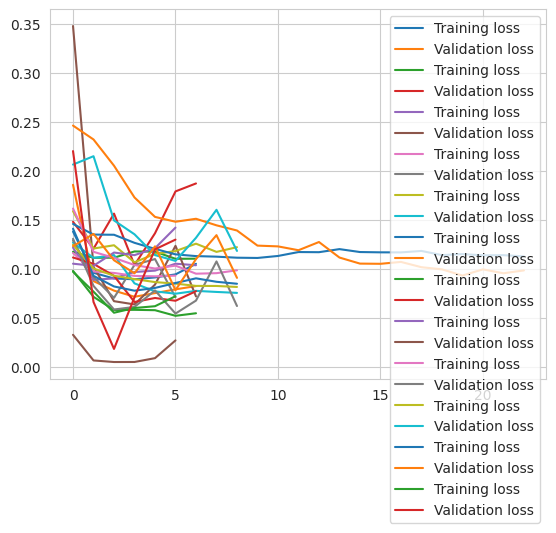

In [ ]:
LSTM_autoencoder_anomaly_detection(30)

Based on our anomaly detection analysis, it seems that the major decrease in stock prices occurred between March 12, 2020, and April 27, 2020. This is an interesting finding that seems to contradict our hypothesis! There was just one very large decrease in stock prices in the middle of 2020, and not a sustained decline. This allows us to transition to the next part of our analysis.

## Statistical Analysis
So far, we have:
1. Fit a linear regression model on the percentage change in stock prices for each sector. The result was that none of the linear models showed a major correlation between COVID cases/deaths/vaccinations and stock price percentage changes, independent of sector.
2. Fit an LSTM model for anomaly detection, and identified the dates in which the largest percent decrease in stock price occurred.

However, the question of which sector was most heavily affected by the COVID pandemic still remains unclear. Therefore, using the dates acquired from the LSTM model, we will perform a **statistical analysis**, independent of the COVID dataset, to determine which sectors were most affected.

In order to perform our statistical analysis, we will once again take the aggregated ```aggregated_sectors_df``` from above, and perform a two-sample $t$-test between each of the sectors to determine whether the difference between average percentage change in stock price over the designated time period is statistically significant (for each sector).

In [ ]:
## Remove later
anomalies_dictionary = anamoly_dates_dict

#### Attempt One: Anomaly Detection Data
The steps that we take here are as follows:
1. We filter out sector data for the anomaly dates for each sector as determined by the LSTM.
2. We use aggregation to get the average percent change for each company in each sector. These averages will be the sample points passed to the $t$-test.
3. We perform the $t$-test and get the sample $p$ value, which is our comparison metric.
4. We repeat this for all pairs of sectors, for-looping through each one.
5. Once we have computed all p-values, we can compute a correlation heatmap to show the $t$-test scores between each of the sectors using seaborn.

**NOTE:** The energy sector and industrials sector did not have an anomaly in the data, and therefore, this code includes an exception for this sector - we use the dates from the other sector being analysed.

In [ ]:
## Excluding energy, industrials for now
sectors = ['Basic Materials', 'Communication Services', 'Consumer Cyclical', 'Consumer Defensive', 'Financial Services', 'Healthcare', 'Real Estate', 'Technology', 'Utilities']

In [ ]:
p_scores = []
differences = []
percent_changes = []
for sector_1 in sectors:
  psector1 = []
  diffsector1 = []
  appendOnce = True
  for sector_2 in sectors:
    ## Filter by anomaly dates
    sector_1_df = joined_sectors_df[joined_sectors_df['sector'] == sector_1]
    sector_2_df = joined_sectors_df[joined_sectors_df['sector'] == sector_2]

    ## Do some brief preprocessing to get data ready for aggregation
    sector_1_df = sector_1_df.transpose()
    sector_1_df = sector_1_df.drop(labels = ['company_name', 'ticker', 'sector', 'Ticker'])
    sector_1_df['Date'] = dates

    sector_2_df = sector_2_df.transpose()
    sector_2_df = sector_2_df.drop(labels = ['company_name', 'ticker', 'sector', 'Ticker'])
    sector_2_df['Date'] = dates
    

    ## Filter by anomaly dates for each sector
    sector_1_df = sector_1_df[sector_1_df['Date'] <= np.max(pd.to_datetime(anomalies_dictionary[sector_1]))]
    sector_1_df = sector_1_df[sector_1_df['Date'] >= np.min(pd.to_datetime(anomalies_dictionary[sector_1]))]
    sector_2_df = sector_2_df[sector_2_df['Date'] <= np.max(pd.to_datetime(anomalies_dictionary[sector_2]))]
    sector_2_df = sector_2_df[sector_2_df['Date'] >= np.min(pd.to_datetime(anomalies_dictionary[sector_2]))]

    ## Perform aggregation to get the average percent change over that period of time for each company
    sector_1_df = sector_1_df.drop(columns = 'Date').mean().tolist()
    sector_2_df = sector_2_df.drop(columns = 'Date').mean().tolist()

    ## Perform the t-test and then add the values to the array
    t_value, p_value = ttest_ind(sector_1_df, sector_2_df, nan_policy = 'raise')
    psector1.append(p_value)
    diffsector1.append(np.mean(sector_1_df) - np.mean(sector_2_df))
    if appendOnce:
      percent_changes.append(np.mean(sector_1_df))
      appendOnce = False

  p_scores.append(psector1)
  differences.append(diffsector1)

In [ ]:
## Converting to numpy arrays to pass to seaborn
p_scores = np.array(p_scores)
differences = np.array(differences)

##### Graphs for the $p$-values and Average Stock Percent Changes

Now that we have computed the $p$-values (which determine whether the two sectors' sample average percentage decreases are far enough in order to be considered statistically significant) and the differences in percentage change between each pair of sectors, we can make a few plots:
* A bar graph depicting the percentage change over the anomaly period for each sector.
* A heatmap plot depicting the differences in percentage change between pairs of sectors.
* A heatmap plot depicting the $p$-values (as the $t$-test results).

Text(0.5, 1.0, 'Average Percentage Changes per Sector over the Anomaly Period')

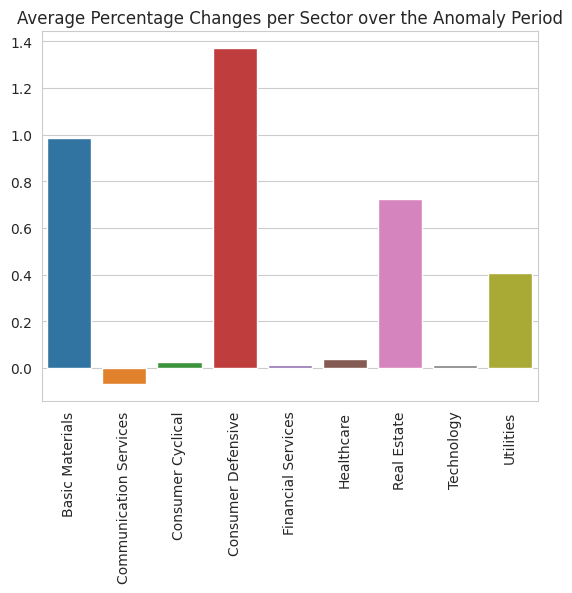

In [ ]:
sns.barplot(data = None, x = sectors, y = percent_changes)
plt.xticks(rotation = 90)
plt.title('Average Percentage Changes per Sector over the Anomaly Period')

Text(50.722222222222214, 0.5, 'Sector 2')

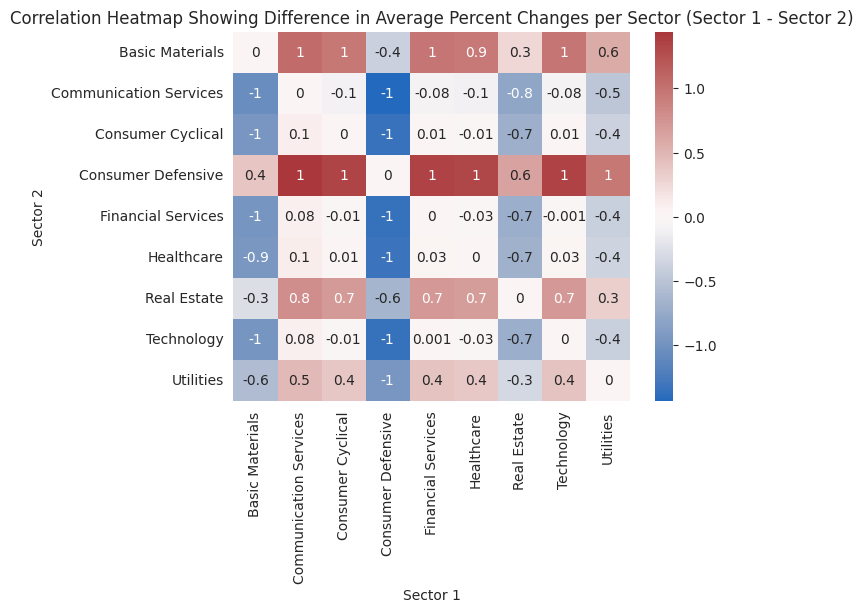

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(differences, 
            cmap = 'vlag',
            annot = True,
            fmt = ".0g")

# Change tick labels
ax.set_xticklabels(sectors)
ax.set_yticklabels(sectors)

# Rotation so that the labels are visible
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.title('Correlation Heatmap Showing Difference in Average Percent Changes per Sector (Sector 1 - Sector 2)')
plt.xlabel('Sector 1')
plt.ylabel('Sector 2')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0, 0.5, 'Basic Materials'),
  Text(0, 1.5, 'Communication Services'),
  Text(0, 2.5, 'Consumer Cyclical'),
  Text(0, 3.5, 'Consumer Defensive'),
  Text(0, 4.5, 'Financial Services'),
  Text(0, 5.5, 'Healthcare'),
  Text(0, 6.5, 'Real Estate'),
  Text(0, 7.5, 'Technology'),
  Text(0, 8.5, 'Utilities')])

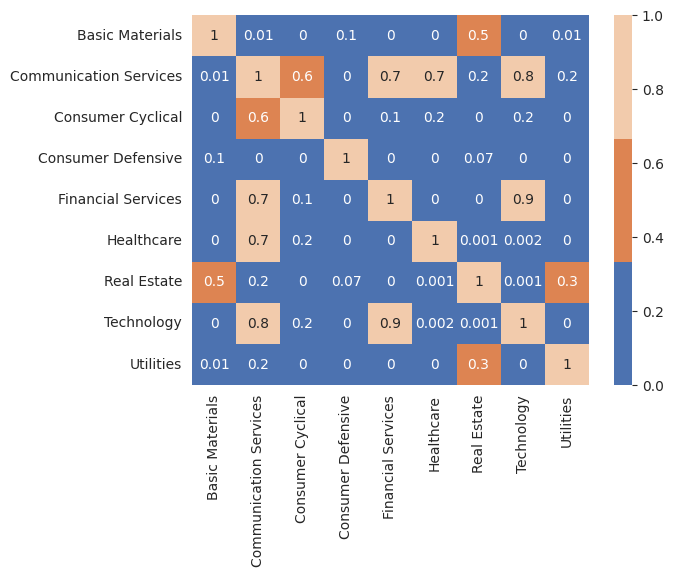

In [ ]:
fig, ax = plt.subplots()

colors = ["#4C72B0", "#DD8452", '#f2cbac']
cmap = sns.color_palette(colors)

# create a mask for non-significant correlations
arr = np.array(p_scores)
# mask = arr < 0.5

pd_arr = pd.DataFrame(arr)
pd_arr = pd_arr.round(3)

sns.heatmap(pd_arr, 
            cmap = cmap,
            fmt = ".0g",
            annot=True,)
            

ax.set_xticklabels(sectors)
ax.set_yticklabels(sectors)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)

##### Attempt One Conclusions
According to the statistical analysis tests, most of our statistical tests were significant. There were a few noticeable exceptions, including:
* The Consumer Cyclical and Basic Materials pairing
* The Consumer Cyclical and Healthcare pairing
* The Financial Services and Technology pairing

This indicates that these sectors in each pair were similarly affected by the pandemic.

It's also interesting to note that, on the differences plot, the Real Estate and Utilities sectors were more negatively affected compared to most sectors. For the Real Estate sector, this is unsurprising, as people were less likely to sell homes during an economic downturn or to have other people tour their home when selling it. However, for the Utilities sector, this is somewhat surprising, as electricity and water always needs to be provided to houses, even during the pandemic.

However, there is one very striking concern with this analysis. **Almost all of the stock percentages increased over the anomaly days.** This could be due to a multititude of reasons, but most likely because our LSTM detected the immediate spike in stock prices after the initial drop as the anomaly. For this reason, we were unsatisfied with this analysis, and decided to perform the analysis on manually selected dates that encapsulate only the main drop in prices based on the previous graphs in the EDA.

#### Attempt Two: Manually Selected Dates based on EDA
This time, instead of using anomaly dates, we will manually select the dates based on EDA (more specifically, the Delta Airlines stock price graph from above). Since we now have a timeframe for each sector, we can add back the Energy sector and the Industrials sector to our list of sectors to analyse.

In [ ]:
## Now that we are doing the analysis on non-anomaly dates, we can add back Energy and Industrials that did not have an anomaly date
sectors.append('Energy')
sectors.append('Industrials')

In [ ]:
p_scores = []
differences = []
percent_changes = []
for sector_1 in sectors:
  psector1 = []
  diffsector1 = []
  appendOnce = True
  for sector_2 in sectors:
    ## Filter by anomaly dates
    sector_1_df = joined_sectors_df[joined_sectors_df['sector'] == sector_1]
    sector_2_df = joined_sectors_df[joined_sectors_df['sector'] == sector_2]

    ## Do some brief preprocessing to get data ready for aggregation
    sector_1_df = sector_1_df.transpose()
    sector_1_df = sector_1_df.drop(labels = ['company_name', 'ticker', 'sector', 'Ticker'])
    sector_1_df['Date'] = dates

    sector_2_df = sector_2_df.transpose()
    sector_2_df = sector_2_df.drop(labels = ['company_name', 'ticker', 'sector', 'Ticker'])
    sector_2_df['Date'] = dates
    

    ## Filter by anomaly dates for each sector
    sector_1_df = sector_1_df[sector_1_df['Date'] <= pd.to_datetime('3/01/2020')]
    sector_1_df = sector_1_df[sector_1_df['Date'] >= pd.to_datetime('10/01/2019')]
    sector_2_df = sector_2_df[sector_2_df['Date'] <= pd.to_datetime('3/01/2020')]
    sector_2_df = sector_2_df[sector_2_df['Date'] >= pd.to_datetime('10/01/2019')]

    ## Perform aggregation to get the average percent change over that period of time for each company
    sector_1_df = sector_1_df.drop(columns = 'Date').mean().tolist()
    sector_2_df = sector_2_df.drop(columns = 'Date').mean().tolist()

    ## Perform the t-test and then add the values to the array
    t_value, p_value = ttest_ind(sector_1_df, sector_2_df, nan_policy = 'raise')
    psector1.append(p_value)
    diffsector1.append(np.mean(sector_1_df) - np.mean(sector_2_df))
    if appendOnce:
      percent_changes.append(np.mean(sector_1_df))
      appendOnce = False

  p_scores.append(psector1)
  differences.append(diffsector1)

##### Graphs for the $p$-values and Average Stock Percent Changes
We will plot the same graphs as the ones from Attempt One.

Text(0.5, 1.0, 'Average Percentage Changes per Sector over the Anomaly Period')

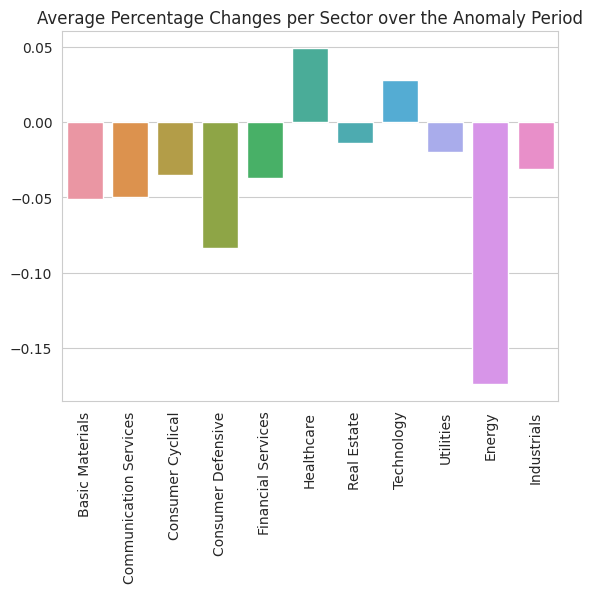

In [ ]:
sns.barplot(data = None, x = sectors, y = percent_changes)
plt.xticks(rotation = 90)
plt.title('Average Percentage Changes per Sector over the Anomaly Period')

Text(70.72222222222221, 0.5, 'Sector 2')

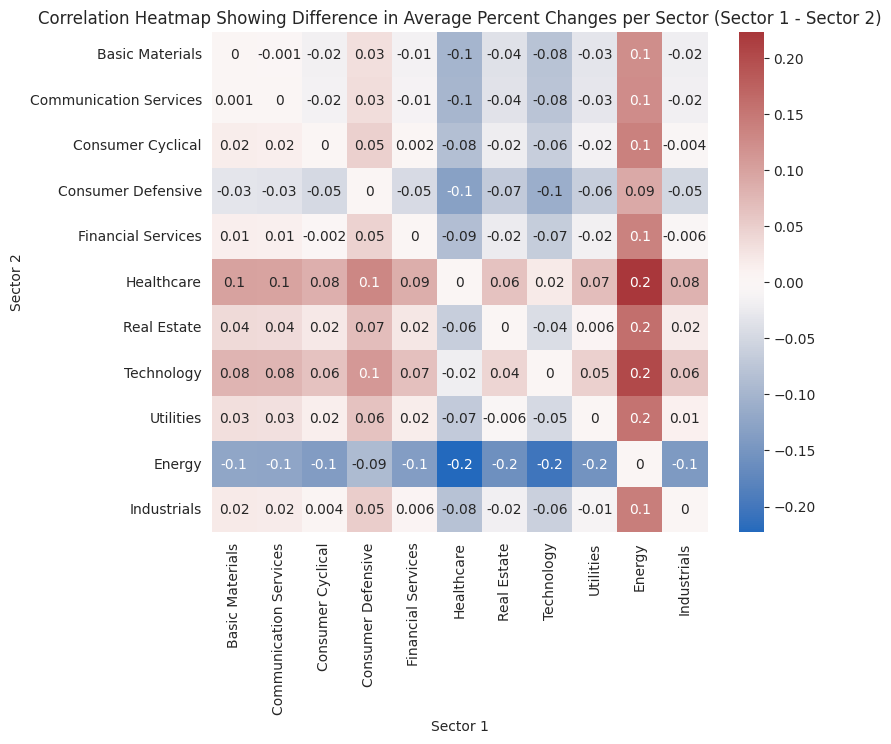

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6.5))

colors = ["#FFC300", "#900C3F", "#581845", "#1D1B1B", "#000000"]
cmap = sns.color_palette(colors)

sns.heatmap(differences, 
            cmap = 'vlag',
            annot = True,
            fmt = ".0g",
            center = 0)

# Change tick labels
ax.set_xticklabels(sectors)
ax.set_yticklabels(sectors)

# Rotation so that the labels are visible
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.title('Correlation Heatmap Showing Difference in Average Percent Changes per Sector (Sector 1 - Sector 2)')
plt.xlabel('Sector 1')
plt.ylabel('Sector 2')


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0, 0.5, 'Basic Materials'),
  Text(0, 1.5, 'Communication Services'),
  Text(0, 2.5, 'Consumer Cyclical'),
  Text(0, 3.5, 'Consumer Defensive'),
  Text(0, 4.5, 'Financial Services'),
  Text(0, 5.5, 'Healthcare'),
  Text(0, 6.5, 'Real Estate'),
  Text(0, 7.5, 'Technology'),
  Text(0, 8.5, 'Utilities'),
  Text(0, 9.5, 'Energy'),
  Text(0, 10.5, 'Industrials')])

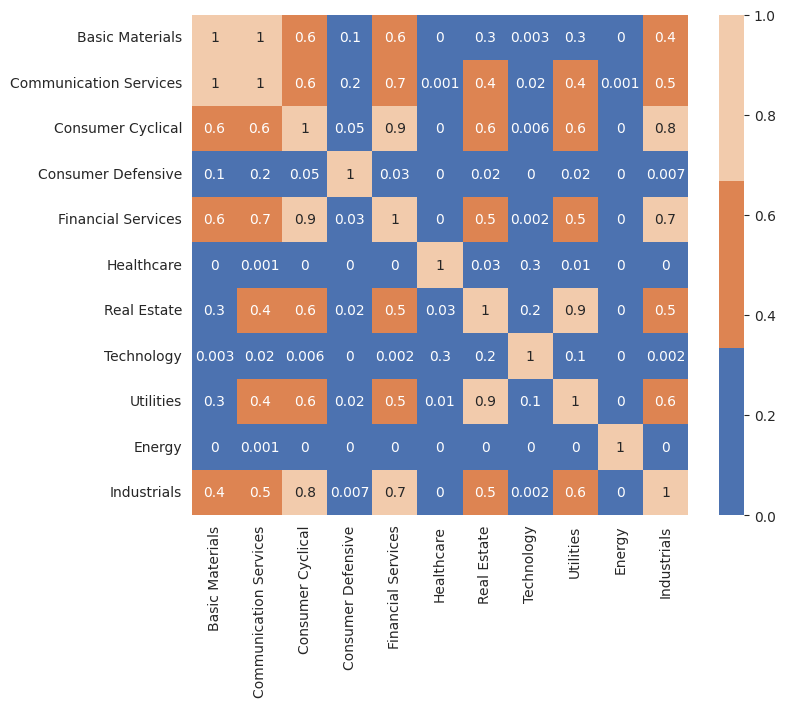

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6.5))

colors = ["#4C72B0", "#DD8452", '#f2cbac']
cmap = sns.color_palette(colors)

# create a mask for non-significant correlations
arr = np.array(p_scores)
# mask = arr < 0.5

pd_arr = pd.DataFrame(arr)
pd_arr = pd_arr.round(3)

sns.heatmap(pd_arr, 
            cmap = cmap,
            fmt = ".0g",
            annot=True,)

# sns.heatmap(p_scores, 
#             cmap = 'vlag',
#             annot = True,
#             fmt = ".0g")

ax.set_xticklabels(sectors)
ax.set_yticklabels(sectors)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)

##### Attempt Two Conclusions:
This is a lot closer to what we expected! All of the percentage changes were negative (with the exception of the Healthcare and Utilities sector - it would make sense why these sectors have a positive percent change), and the only real noticeable significant differences, according to the $t$-test involved the Energy sector (which experienced a massive decrease in stock prices, the Technology sector (which was not nearly has negatively affected as some of the other sectors - this makes sense, as companies like Zoom and Google likely benefitted during the pandemic due to remote learning and remote work), and the Healthcare and Utilities sectors mentioned before.

# Section 4: Overall Results

In summary, through our analysis, we made the following discoveries:
1. When it came to different sectors being affected by COVID-19, not all sectors were affected equally. For example, the Healthcare, Technology, and Utilities sector were not affected as heavily as other sectors, especially the Energy sector. 
2. We also discovered that the main anomaly detected here was not for the massive decrease in stock prices, but rather the resulting rebound that occurred afterwards. 
3. In addition to this, we learned that the main decrease in stock price was not necessarily due to the rise of COVID cases, but rather due to the scare or shock that came from the start of the pandemic.
[EDA stuff]

# Section 5: Discussion, Limitations, and Future Directions

## Main Challenges
The main challenges associated with this project was the integration of multiple different data sources. For example, we needed to merge the tickers for each of the companies on the sector for each of those tickers, and we also needed to merge COVID and Vaccination data on the dates. Importing and dealing with data in different formats, and preprocessing/wrangling the data into a form that would allow us to join easily was a significant challenge in our project. This challenge meant that we needed to save many of our dataframes as CSV files and then reload them (for example, webscraping the data took 40+ minutes each time we ran it).

Dealing with time-series data was also a challenge. As a result, many of our models do not focus on classification, but rather on identifying trends using statistics, linear regression and the LSTM model. We also invested a lot of time into performing a comprehensive EDA and with graphs to show the relationship between several related but different variables (for example, the relationship between profit and stock prices allowed us to tie the drop in stock prices to a drop in profit for each sector).

## Future Directions

We have considered several additional future directions based on our work here:

### Additional Analyses using our Current Data

We could have expanded our $t$-tests to overall stock percentage changes during the pandemic. Currently, we had a $t$-test for the average change in price each day, but it would be interesting to see if the trends we observed here also held for an overall percent change over the entire COVID pandemic (rather than breaking it down by day). We could also have applied linear regression to other possible relationships, such as the relationship between COVID vaccinations and new COVID cases to determine whether COVID vaccinations were really able to prevent more people from getting sick. Although this is tangential to the stock price data, it would help us to connect vaccinations to COVID cases more directly.

### Relation to Other Major Disruptions

We can compare our analysis by sector with other disruptions, such as the 2008 Financial Crisis and the more recent 2022 Russian Invasion of Ukraine. This would allow us to see whether or not different sectors from these were affected during the pandemic, and therefore to see how different types of disruptions affected different sectors.

### Predictive Modelling and Disruption Simulation

Adding on to the above point, it may be possible to create a simulation model that simulates the effect of a theoretical disruption on stock prices given data from previous disruptions. This would be far more advanced than our current analyses here, as we'll practically need to write a state-of-the-art machine learning/simulation model!

### Startup Company Success

Since so many Penn students are interested in entrepreneurship, we can use stock data from new companies or start-up companies during the COVID pandemic to see which companies remained successful, and which didn't survive. This may be challenging, as we would only have access to stock prices of companies that have gone public, and there may not be many start-ups that have gone public. Nevertheless, working with a smaller dataset of companies may allow us to do additional research into what these specific companies did that made them successful (or unsuccessful) during the COVID pandemic, and therefore provide valuable business insights for start-up company founders.

# Section 6: Conclusion

For our final project, we conducted an in-depth analysis of the impact of COVID data on the stock market, analysing the relationship between COVID-19 cases, vaccinations, death, and stock prices, detecting anomalies in the stock data due to the COVID-19 pandemic, and analysing the effect of COVID-19 on individual sectors using a rigorous statistical analysis. Here are the answers to our hypotheses:
1. The first hypothesis that there would be a strong linear trend between cases,deaths, and vaccinations was only partially supported while the $R^2$ values were high enough to show a strong linear relation for stock prices, this was not the case for stock price percentage change, and the signs of the coefficients of the model didn't necessarily reflect this either.
2. The anomaly did not agree with our predictions, coming after the initial spike. This is likely due to lack of time series data.
3. Rigorous statistical testing showed that there were sectors that were more significantly impacted than others. These generally agreed with our hypotheses (for example, it was unsurprising that healthcare was not heavily affected).